# RTED-TDS Co-Sim

Authored by [Jinning Wang](https://scholar.google.com/citations?user=Wr7nQZAAAAAJ&hl=en&oi=ao), recently updated on 06/06/2022.

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented with an equation defined PI controller.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted2`` has attributes ``mdl`` which is a gurobipy model.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, matplotlib, scipy

## Import case

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from math import floor

import andes
from andes.interop.pandapower import to_pandapower, make_link_table, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table
andes.config_logger(stream_level=20)

import pandapower as pp

from jams import rted2

from ev_ssm import ev_ssm

Package version

In [2]:
print(andes.__version__)
print(pp.__version__)

1.7.1.post236.dev0+g88b205cd
2.8.0


EV aggregator

`caseH` is the start time [H] of the co-simulation, now 10 and 18 are supported.

In [3]:
caseH = 10
sse = ev_ssm(ts=caseH, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA")
sse.load_A("Aest.csv")

EVA: ts=10[H], 10000 EVs, Total Q=250.12 MWh
Online 1983, Q=49.73 MWh, SoC=0.9834
Power(MW): Pt=-0.3613, Pc=-0.3613, Pd=-0.0
Ctrl: 0=1921; 1=62; 
EVA: Load A from Aest.csv.


Import ADNES case

In [4]:
# ss0 is used for PP conversion
dir_path = os.path.abspath('..')
case_path = '/case/ieee39_ev2.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)
stg0idx = ssa.PV.idx.v + ssa.Slack.idx.v
pm0 = ssa.StaticGen.get(src='pmax', attr='v', idx=stg0idx)
ssa.StaticGen.set(src='pmax', attr='v', idx=stg0idx, value=2*pm0)

Working directory: "/home/jwang175/andes/jwang/notes2"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Loaded generated Python code in "/home/jwang175/.andes/pycode".
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.0910 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0409 seconds.


True

Set output mode as 'manual'

In [5]:
ssa.TDS.config.save_mode = 'manual'

Set load as constant load.

In [6]:
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

Turn on ``numba`` can accelerate TDS.

In [7]:
ssa.config.numba

1

## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


Text(0.5, 0, 'Time [s]')

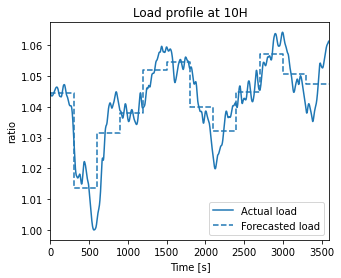

In [8]:
# --- read load from ssa ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale load curve ---
ddata_path = '/case/dsyn.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

# the coefficient can be adjusted to fit the case
if caseH == 10:
    d_syn['sload'] = 0.8*(d_syn['ha10'] - d_syn['ha10'].min()) / d_syn['ha10'].min() + 1
if caseH == 18:
    d_syn['sload'] = 2*(d_syn['ha18'] - d_syn['ha18'].min()) / d_syn['ha18'].min() + 1

# smooth
d_syn['sload'] = d_syn['sload'].rolling(20).mean()
    
# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0,3600,300)

# align starting point of load with starting point of dispatch results
d_syn['sload'][0] = d_exp['sload'].iloc[0]
d_syn['sload'][1:100] = None
d_syn['sload'] = d_syn['sload'].interpolate(method='polynomial', order=3)

# --- plot load curve ---
fig_load, ax_load = plt.subplots(figsize=(5, 4))
ax_load.plot(d_syn['time'], d_syn['sload'], color='tab:blue', linestyle='-')
ystep = list(d_exp['sload'])
ystep.insert(0, d_exp['sload'].iloc[0])
ax_load.step(range(0,3900,300), ystep, color='tab:blue', linestyle='--')
ax_load.set_xlim([0, 3600])
ax_load.legend(['Actual load', 'Forecasted load'])
ax_load.set_title(f'Load profile at {caseH}H')
ax_load.set_ylabel('ratio')
ax_load.set_xlabel('Time [s]')

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [9]:
# --- set up EV generator data ---

ev_idx = 'PV_10'
ssa.PV.set(src='p0', idx=ev_idx, attr='v', value=sse.Ptc)
ssa.PV.set(src='pmax', idx=ev_idx, attr='v', value=sse.Pu)
ssa.PV.set(src='pmin', idx=ev_idx, attr='v', value=sse.Pl)

True

In [10]:
# --- convert to a pandapower instance ---
ssp = to_pandapower(ssa)

# set EV generator as uncontrollable
ssp.gen.controllable.iloc[9] = False

# add gen cost, G1-11. G10 EV, G11 Slack
linearcost = [1, 1, 1, 1, 1, 1, 1, 1, 1, 0.1, 1.5]

gen_cost = np.array([[2., 0., 0., 3., 0., 0., 0.]] * ssp.gen.shape[0])
gen_cost[:, 5] = linearcost  # c1

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1024 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916599385
2: |F(x)| = 0.1314306449
3: |F(x)| = 0.000346374201
4: |F(x)| = 4.221393901e-09
Converged in 5 iterations in 0.0084 seconds.
Power flow results are consistent. Conversion is successful.


True

In [11]:
ssp.gen

,name,slack,bus,p_mw,vm_pu,controllable,in_service,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,slack_weight,scaling,sn_mva
0,PV_1,False,29,436.086385,1.035534,True,True,3000.0,200.0,183.816,-58.084,0.0,1,100
1,PV_2,False,30,645.999998,1.013246,True,True,1800.0,150.0,515.7648,-122.665,0.0,1,100
2,PV_3,False,31,724.999998,1.020528,True,True,1600.0,100.0,536.0664,-180.218,0.0,1,100
3,PV_4,False,32,651.999998,1.01343,True,True,1400.0,100.0,657.8496,-213.78,0.0,1,100
4,PV_5,False,33,520.0,1.019109,True,True,1400.0,100.0,733.794,-188.028,0.0,1,100
5,PV_6,False,34,690.0,1.06,True,True,1600.0,100.0,712.5456,-234.972,0.0,1,100
6,PV_7,False,35,590.0,1.06,True,True,1400.0,100.0,682.0464,-249.132,0.0,1,100
7,PV_8,False,36,330.0,1.013996,True,True,1400.0,100.0,532.1616,-216.122,0.0,1,100
8,PV_9,False,37,780.0,1.052803,True,True,2000.0,100.0,1001.73,-356.889,0.0,1,100
9,PV_10,False,37,-36.128532,1.052803,False,True,1144.862135,-38.104337,0.0,0.0,0.0,1,100


Set RTED instance ``ssd``

In [12]:
ssd = rted2()
ssd.from_andes(ssa)

# set EV generator as uncontrollable
ssd.gen.ctrl.iloc[9] = 0

# set EV geenrator as type2
prumax = sse.g_frc()[0]
prdmax = sse.g_frc()[1]
ssd.def_type2([ev_idx], [prumax], [prdmax])

# set ramp5
ramp_hour = [999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999]
# ramp_hour = [80, 80, 80, 50, 50, 50, 30, 30, 30, 999, 30]
ssd.gen.ramp5 = np.array(ramp_hour) * 10 / 12 / ssd.mva

# set cost
ssd.cost.c1 = linearcost

# adjust SFR cost of EV lower than SynGen
ssd.cost.cru = 0.1
ev_loc = ssd.cost[ssd.cost.idx == ev_idx].index[0]
ssd.cost.cru.iloc[ev_loc] = 0.0999
ssd.cost.crd = ssd.cost.cru

# update p_pre from standard DCOPF results
ssd.set_p_pre()

# sovle the RTED
ssd.get_res()

Restricted license - for non-production use only - expires 2023-10-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0076 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916599385
2: |F(x)| = 0.1314306449
3: |F(x)| = 0.000346374201
4: |F(x)| = 4.221393901e-09
Converged in 5 iterations in 0.0078 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0xaa867f21
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [6e+01, 2e+03]
Presolve removed 69 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0389157e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.038915679e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.
No RegUp requirement data (``du``), set to 0.
No RegDn requirement data (``dd``), set to 0.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xf213fb90
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [2e-02, 2e+03]
Presolve removed 117 rows and 33 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0389157e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.038915679e+01


Successfully solve RTED.


,gen,pg,pru,prd,bu,bd
0,PV_1,15.925285,0.0,0.0,0.0,0.0
1,PV_2,9.675000,0.0,0.0,0.0,0.0
2,PV_3,7.675000,0.0,0.0,0.0,0.0
3,PV_4,1.000000,0.0,0.0,0.0,0.0
4,PV_5,1.000000,0.0,0.0,0.0,0.0
5,PV_6,1.000000,0.0,0.0,0.0,0.0
6,PV_7,1.000000,0.0,0.0,0.0,0.0
7,PV_8,9.325000,0.0,0.0,0.0,0.0
8,PV_9,9.325000,0.0,0.0,0.0,0.0
9,PV_10,-0.361285,0.0,0.0,0.0,0.0


Benchmark ``ssd`` with ``ssp`` using standard DCOPF

In [13]:
pp.rundcopp(ssp)
ppres = ssp.res_gen.copy()
ssdc = ssd.to_dcopf()
gb_res = ssdc.get_res()
ppres['p_mw(GB)'] = ssp.sn_mva * gb_res['pg'].values
print(f"pp cost={ssp.res_cost}, gb cost={ssd.res_cost}")
ppres

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0xaa867f21
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [6e+01, 2e+03]
Presolve removed 69 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0389157e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.038915679e+01


Successfully solve DCOPF.


pp cost=6038.915679405395, gb cost=60.3891567865185


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,410.347230,92.622757,8.715538,1.0,1592.528532
1,560.494839,311.488301,8.413961,1.0,1800.000000
2,891.073553,149.407550,16.342173,1.0,1600.000000
3,557.166392,131.140357,12.880104,1.0,100.000000
4,557.207500,146.559740,12.798863,1.0,100.000000
5,482.830109,227.749422,13.919143,1.0,100.000000
6,671.394922,63.219181,20.746312,1.0,100.000000
7,331.934923,-27.585564,9.786085,1.0,100.000000
8,1130.079063,118.941642,28.419366,1.0,100.000000
9,-36.128532,0.000000,28.419366,1.0,-36.128532


## Prepare

### Make link table

In [14]:
# --- link_table ---
ssa_key = make_link_table(ssa)

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})
ssa_key2 = pd.merge(left=ssa_key,
                    right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                    on='stg_idx', how='left')

# --- device idx ---
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist()
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist()

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl & ssa_key2.stg_u.astype(bool)
ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)

ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


### Define functions used in loop

In [15]:
# --- def. functions ---

def get_pe(ssa, gov_idx, dg_idx, ssa_key2):
    """Get the active power (TurbineGov/DG) after TDS, a DataFrame"""
    # TODO: may need to sum the power of same StaticGen
    # --- TurbineGov --- 
    pe_syg = ssa.TurbineGov.get(src='pout', idx=gov_idx, attr='v')
    # --- DG ---
    Ip_dg = ssa.DG.get(src='Ipout_y', idx=dg_idx, attr='v')
    v_dg = ssa.DG.get(src='v', idx=dg_idx, attr='v')
    pe_dg = Ip_dg*v_dg
    # --- out ---
    pe = pd.DataFrame()
    pe['idx'] = gov_idx + dg_idx
    pe['pe'] = np.concatenate((pe_syg, pe_dg))
    ldf = pd.merge(left=ssa_key2.rename(columns={'dg_idx':'idx'}),
         right=pe, how='right', on='idx')
    rdf = pd.merge(left=ssa_key2.rename(columns={'gov_idx':'idx'}),
             right=pe, how='right', on='idx')
    pe['stg_idx'] = ldf['stg_idx'].fillna('') + rdf['stg_idx'].fillna('')
    return pe

def dp_calc(d_syn, idx_ed, intv_ed, ratio=100):
    """Calc SFR requirements, scalars, ``dpd_u``and ``dpd_d``, and load forecasted value ``load_exp``"""
    load = d_syn['sload'].iloc[idx_ed*intv_ed:(idx_ed*intv_ed + intv_ed)]
    load_exp = load.mean()
    # TODO: check if the estimation is reasonable
    load_ci = stat.t.interval(alpha=0.95, df=len(load)-1, loc=np.mean(load), scale=stat.sem(load))
    load_d = abs(load_ci[0] - load_exp) * ratio
    load_u = abs(load_ci[1] - load_exp) * ratio
    return load_u, load_d, load_exp

## Define param

In [16]:
# --- co-sim constants ---
t_total = 3600    # total simulation time

# length of each interval
intv_ed = 300  # RTED interval, 300s
intv_agc = 4    # AGC interval, 4s
intv_pq = 1     # PQ interval, 1s; alter load and AGC
intv_step = 100 # step change interval; smooth the setpoitns

# number of each interval
n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# --- vars ---
# AGC table
agc_table = ssp.gen[['name']].rename(columns={'name':'stg_idx'})
agc_table['paux'] = 0
agc_res = agc_table[['stg_idx']].copy()

# ACE vars for PI controller
ACE_integral = 0
ACE_raw = 0
Kp = 0.2 # 0.05
Ki = 0.05
ace_res = pd.DataFrame()

# initial load value
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

Check if RTED converge in all 12 intervals

In [17]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = ssp.gen.max_p_mw

# store original generator data
ssp_gen0 = ssp.gen.copy()

for end_time in range(t_total):  # t_total
    # --- interval RTED ---
    if end_time % intv_ed == 0:
        idx_ed = end_time // intv_ed
        # --- update load ---
        du, dd, load_exp = dp_calc(d_syn, idx_ed, intv_ed, ratio=100)
        ssp.load.scaling = load_exp
        ssd.load['p0'] = ssa_p0 * load_exp
        ssd.update_dict()

        # --- RTED, update gen limits after SFR ---
        # initially set previous setpoints with standard DCOPF results
        # or set `pe` from TDS
        if end_time > 0:
            pe_tds = get_pe(ssa, ssa_gov_idx, ssa_dg_idx, ssa_key2)
            pe_tds = pe_tds.merge(ssa_key2, on='stg_idx',
                                  how='right').groupby('stg_idx', as_index=False).sum()
            p_pre = pe_tds
            ssd.gen.p_pre = pd.merge(left=ssd.gen, how='left', on='idx',
                                     right=pe_tds[['stg_idx', 'pe']].rename(columns={'stg_idx': 'idx'}))['pe']
        else:
            ssd.set_p_pre()
            p_pre = ssd.gen[['idx', 'p_pre']].rename(columns={'p_pre': 'pe', 'idx': 'stg_idx'})

        # def. SFR requirements and calc. EV SFR capacities
        [prumax, prdmax] = sse.g_frc()
        # def. percentage of EV SFR capacities
        ssd.def_type2([ev_idx], [prumax*0.0], [prdmax*0.0])
        ssd.def_sfr(du=du*ssa_p0_sum, dd=dd*ssa_p0_sum)

        # solve RTED
        dcres = ssd.get_res() 

        # reserve SFR and ramp from Generator limits in ``ssp``
        ssp_gen = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                           right=dcres.rename(columns={'gen': 'stg_idx'}),
                           on='stg_idx', how='left')
        # SFR limits
        ssp_gen['max_sfr'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['min_sfr'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva
        # ramp limits
        p_pre_pp = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                            right=p_pre[['stg_idx', 'pe']],
                            on='stg_idx', how='left')['pe']
        ssp_gen['max_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) + np.array(ssd.gen.ramp5))
        ssp_gen['min_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) - np.array(ssd.gen.ramp5))
        # alter generator limits
        ssp.gen.max_p_mw = ssp_gen[['max_sfr', 'max_ramp']].min(axis=1)
        ssp.gen.min_p_mw = ssp_gen[['min_sfr', 'min_ramp']].max(axis=1)

        # --- ACOPF, modify setpoints ---
        # store setpoints
        if end_time > 0:
            p0 = ssp_res['p'].values  # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # solve ACOPF
        ssp_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ssp_res['p0'] = p0                  # last setpoints
        ssp_res.fillna(False, inplace=True)  # Fill NA wil False

        # reset Generator limtis to normal limits
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

    # --- interval AGC ---
    ace_gain = 1
    if end_time % intv_agc == 0:
        idx_agc = end_time // intv_agc - idx_ed * n_agc
        # --- allocate AGC ---
        # --- calc. AGC ---
        ACE_input = min(ACE_raw, dcres.pru.sum())
        if ACE_raw >= 0:
            ACE_input = min(ACE_raw, dcres.pru.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bu.values
        else:
            ACE_input = max(ACE_raw, -1 * dcres.prd.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bd.values
        agc_res[f'{end_time}'] = agc_table['paux']
        ace_data = [end_time, ACE_raw, dcres.pru.sum(),
                    -1*dcres.prd.sum(), ACE_input]
        ace_new = pd.DataFrame([ace_data], columns=['time', 'ace', 'up', 'dn', 'in'])
        ace_res = pd.concat([ace_res, ace_new])

        # --- assign AGC ---
        # a.SynGen
        agc_syg = pd.merge(left=agc_table,
                           right=ssa_key2,
                           on='stg_idx', how='right')
        agc_syg['paux2'] = agc_syg.paux * agc_syg.gammap
        cond_gov = agc_syg.ctrl * agc_syg.gov_idx.astype(bool)
        agc_gov = agc_syg.gov_idx[cond_gov].tolist()
        ssa.TurbineGov.set(src='paux0', idx=agc_gov, attr='v',
                           value=agc_syg.paux2.values)
        # b.DG;
        agc_dg = pd.merge(left=agc_table,
                          right=ssa_key2,
                          on='stg_idx', how='right')
        agc_dg['paux2'] = agc_dg.paux * agc_dg.gammap
        cond_dg = agc_dg.ctrl * agc_dg.dg_idx.astype(bool)
        agc_dg_idx = agc_dg.dg_idx[cond_dg].tolist()
        ssa.DG.set(src='pext0', idx=agc_dg_idx, attr='v',
                   value=agc_dg.paux2.values)
        # c.EV;
        agc_ev = pd.merge(left=agc_table,
                          right=ssa_key2,
                          on='stg_idx', how='right')
        agc_ev['paux2'] = agc_ev.paux * agc_ev.gammap
        sse_agc = agc_ev[agc_ev.stg_idx == ev_idx].paux2.values

        # --- smooth setpoints ---
        if idx_ed == 0:
            ssp_res['pref'] = ssp_res['p']
        else:
            if idx_agc == 0:
                # only record the pe from TDS in the first AGC interval
                copy = ssp_res.merge(right=pe_tds[['pe', 'stg_idx']], on='stg_idx', how='left')
                ssp_res['pe_tds'] = copy.pe
            idx_step = min((end_time - idx_ed * intv_ed) // intv_agc + 1, n_step)
            ssp_res['pref_step'] = ssp_res.p - ssp_res.p0
            # smooth change threshold: 0.1
            large_index = ssp_res['pref_step'][abs(ssp_res['pref_step']) > 0.01].index
            ssp_res['pref_delta'] = ssp_res['pref_step']
            ssp_res['pref_delta'].iloc[large_index] = ssp_res['pref_step'].iloc[large_index] / n_step * idx_step
            ssp_res['pref'] = ssp_res.p0 + ssp_res.pref_delta

            # update SynGen setpoints
            cond_gov = ssp_res.controllable & ssp_res.gov_idx.astype(bool)
            ssa.TurbineGov.set(src='pref0', idx=ssp_res.gov_idx[cond_gov].tolist(),
                               attr='v', value=ssp_res.pref[cond_gov].values)
            # update DG setpoints;
            cond_dg = ssp_res.controllable & ssp_res.dg_idx.astype(bool)
            ssa.DG.set(src='pref0', idx=ssp_res.dg_idx[cond_dg].tolist(),
                       attr='v', value=ssp_res.pref[cond_dg].values)

    # --- intv_pq: alter load, run TDS ---
    # Initially, alter StaticGen: p0 and q0, RUN power flow
    # Otherwise, alter Ppf and Qpf
    if end_time == 0:
        stg_opf_idx = ssp_res.stg_idx[ssp_res.controllable].tolist()
        stg_opf_val = ssp_res.p[ssp_res.controllable].tolist()
        stg_opf_v = ssp_res.vm_pu[ssp_res.controllable].tolist()
        ssa.StaticGen.set(src='p0', idx=stg_opf_idx, attr='v', value=stg_opf_val)
        ssa.StaticGen.set(src='v0', idx=stg_opf_idx, attr='v', value=stg_opf_v)
        # initial load point set as the dispatch point
        ssa.PQ.set(src='p0', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * load_exp)
        ssa.PQ.set(src='q0', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * load_exp)
        ssa.PFlow.run()
    else:
        ssa.PQ.set(src='Ppf', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * d_syn['sload'].iloc[end_time])
        ssa.PQ.set(src='Qpf', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * d_syn['sload'].iloc[end_time])
        # run `sse`
        sse.run(tf=caseH+end_time/3600, Pi=sse_agc[0],
                is_updateA=True, is_rstate=True,
                is_test=False, disable=True)
        sse.report(is_report=False)
        ssa.DG.set(src='pref0', idx=ssp_res.dg_idx[ssp_res.stg_idx == ev_idx].values[0],
                   attr='v', value=sse.Ptc)

    # run TDS
    ssa.TDS.config.tf = end_time
    if end_time == 0:
        ssa.TDS.init()
    ssa.TDS.run()
    # update AGC PI Controller
    ACE_integral = ACE_integral + ssa.ACEc.ace.v.sum()
    ACE_raw = -(Kp*ssa.ACEc.ace.v.sum() + Ki*ACE_integral)

    # ACE_raw = 0  # delete when run TDS
    # break loop if TDS run into error
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {end_time}s.")


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0xc6f4492f
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [6e+01, 2e+03]
Presolve removed 69 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2930266e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.293026621e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x9a1c18b3
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [4e-01, 2e+03]
Presolve removed 105 rows and 12 columns
Presolve time: 0.00s
Presolved: 12 rows, 21 columns, 39 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3340913e+01   4.162500e+00   0.000000e+00      0s
       1    6.3340913e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.334091253e+01


Successfully solve RTED.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0078 seconds.
0: |F(x)| = 7.959020157
1: |F(x)| = 3.636894196
2: |F(x)| = 0.209084611
3: |F(x)| = 0.0009902656015
4: |F(x)| = 4.145843757e-08
Converged in 5 iterations in 0.0080 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for dynamics completed in 0.3186 seconds.
Initialization was successful.

-> T

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=0.00 sec completed in 0.0009 seconds.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

Current step size is zero. Integration is not permitted.
Simulation to t=1.00 sec completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2.00 sec completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3.00 sec completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=4.00 sec completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=5.00 sec completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=6.00 sec completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=7.00 sec completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=8.00 sec completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=9.00 sec completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=10.00 sec completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=11.00 sec completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=12.00 sec completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=13.00 sec completed in 0.0791 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=14.00 sec completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=15.00 sec completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=16.00 sec completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=17.00 sec completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=18.00 sec completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=19.00 sec completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=20.00 sec completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=21.00 sec completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=22.00 sec completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=23.00 sec completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=24.00 sec completed in 0.0767 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=25.00 sec completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=26.00 sec completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=27.00 sec completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=28.00 sec completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=29.00 sec completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=30.00 sec completed in 0.0653 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=31.00 sec completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=32.00 sec completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=33.00 sec completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=34.00 sec completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=35.00 sec completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=36.00 sec completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=37.00 sec completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=38.00 sec completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=39.00 sec completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=40.00 sec completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=41.00 sec completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=42.00 sec completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=43.00 sec completed in 0.0786 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=44.00 sec completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=45.00 sec completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=46.00 sec completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=47.00 sec completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=48.00 sec completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=49.00 sec completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=50.00 sec completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=51.00 sec completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=52.00 sec completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=53.00 sec completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=54.00 sec completed in 0.0801 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=55.00 sec completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=56.00 sec completed in 0.0848 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=57.00 sec completed in 0.0988 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=58.00 sec completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=59.00 sec completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=60.00 sec completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=61.00 sec completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=62.00 sec completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=63.00 sec completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=64.00 sec completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=65.00 sec completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=66.00 sec completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=67.00 sec completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=68.00 sec completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=69.00 sec completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=70.00 sec completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=71.00 sec completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=72.00 sec completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=73.00 sec completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=74.00 sec completed in 0.0829 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=75.00 sec completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=76.00 sec completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=77.00 sec completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=78.00 sec completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=79.00 sec completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=80.00 sec completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=81.00 sec completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=82.00 sec completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=83.00 sec completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=84.00 sec completed in 0.0828 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=85.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=86.00 sec completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=87.00 sec completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=88.00 sec completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=89.00 sec completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=90.00 sec completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=91.00 sec completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=92.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=93.00 sec completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=94.00 sec completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=95.00 sec completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=96.00 sec completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=97.00 sec completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=98.00 sec completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=99.00 sec completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=100.00 sec completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=101.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=102.00 sec completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=103.00 sec completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=104.00 sec completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=105.00 sec completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=106.00 sec completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=107.00 sec completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=108.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=109.00 sec completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=110.00 sec completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=111.00 sec completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=112.00 sec completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=113.00 sec completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=114.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=115.00 sec completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=116.00 sec completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=117.00 sec completed in 0.0798 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=118.00 sec completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=119.00 sec completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=120.00 sec completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=121.00 sec completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=122.00 sec completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=123.00 sec completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=124.00 sec completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=125.00 sec completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=126.00 sec completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=127.00 sec completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=128.00 sec completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=129.00 sec completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=130.00 sec completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=131.00 sec completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=132.00 sec completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=133.00 sec completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=134.00 sec completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=135.00 sec completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=136.00 sec completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=137.00 sec completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=138.00 sec completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=139.00 sec completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=140.00 sec completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=141.00 sec completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=142.00 sec completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=143.00 sec completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=144.00 sec completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=145.00 sec completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=146.00 sec completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=147.00 sec completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=148.00 sec completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=149.00 sec completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=150.00 sec completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=151.00 sec completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=152.00 sec completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=153.00 sec completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=154.00 sec completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=155.00 sec completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=156.00 sec completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=157.00 sec completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=158.00 sec completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=159.00 sec completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=160.00 sec completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=161.00 sec completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=162.00 sec completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=163.00 sec completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=164.00 sec completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=165.00 sec completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=166.00 sec completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=167.00 sec completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=168.00 sec completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=169.00 sec completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=170.00 sec completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=171.00 sec completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=172.00 sec completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=173.00 sec completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=174.00 sec completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=175.00 sec completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=176.00 sec completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=177.00 sec completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=178.00 sec completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=179.00 sec completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=180.00 sec completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=181.00 sec completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=182.00 sec completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=183.00 sec completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=184.00 sec completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=185.00 sec completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=186.00 sec completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=187.00 sec completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=188.00 sec completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=189.00 sec completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=190.00 sec completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=191.00 sec completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=192.00 sec completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=193.00 sec completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=194.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=195.00 sec completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=196.00 sec completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=197.00 sec completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=198.00 sec completed in 0.0788 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=199.00 sec completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=200.00 sec completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=201.00 sec completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=202.00 sec completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=203.00 sec completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=204.00 sec completed in 0.0800 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=205.00 sec completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=206.00 sec completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=207.00 sec completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=208.00 sec completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=209.00 sec completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=210.00 sec completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=211.00 sec completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=212.00 sec completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=213.00 sec completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=214.00 sec completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=215.00 sec completed in 0.0838 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=216.00 sec completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=217.00 sec completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=218.00 sec completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=219.00 sec completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=220.00 sec completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=221.00 sec completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=222.00 sec completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=223.00 sec completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=224.00 sec completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=225.00 sec completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=226.00 sec completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=227.00 sec completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=228.00 sec completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=229.00 sec completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=230.00 sec completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=231.00 sec completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=232.00 sec completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=233.00 sec completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=234.00 sec completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=235.00 sec completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=236.00 sec completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=237.00 sec completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=238.00 sec completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=239.00 sec completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=240.00 sec completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=241.00 sec completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=242.00 sec completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=243.00 sec completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=244.00 sec completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=245.00 sec completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=246.00 sec completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=247.00 sec completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=248.00 sec completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=249.00 sec completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=250.00 sec completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=251.00 sec completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=252.00 sec completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=253.00 sec completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=254.00 sec completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=255.00 sec completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=256.00 sec completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=257.00 sec completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=258.00 sec completed in 0.0649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=259.00 sec completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=260.00 sec completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=261.00 sec completed in 0.0654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=262.00 sec completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=263.00 sec completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=264.00 sec completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=265.00 sec completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=266.00 sec completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=267.00 sec completed in 0.0655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=268.00 sec completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=269.00 sec completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=270.00 sec completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=271.00 sec completed in 0.0660 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=272.00 sec completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=273.00 sec completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=274.00 sec completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=275.00 sec completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=276.00 sec completed in 0.0811 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=277.00 sec completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=278.00 sec completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=279.00 sec completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=280.00 sec completed in 0.0863 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=281.00 sec completed in 0.0837 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=282.00 sec completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=283.00 sec completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=284.00 sec completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=285.00 sec completed in 0.0847 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=286.00 sec completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=287.00 sec completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=288.00 sec completed in 0.0918 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=289.00 sec completed in 0.0860 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=290.00 sec completed in 0.0793 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=291.00 sec completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=292.00 sec completed in 0.0939 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=293.00 sec completed in 0.0878 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=294.00 sec completed in 0.0848 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=295.00 sec completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=296.00 sec completed in 0.0958 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=297.00 sec completed in 0.0892 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=298.00 sec completed in 0.0937 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=299.00 sec completed in 0.0794 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xf780b14a
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [4e-01, 2e+03]
Presolve removed 97 rows and 5 columns
Presolve time: 0.01s
Presolved: 20 rows, 28 columns, 71 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4581756e+01   7.533697e+01   0.000000e+00      0s
       4    6.2250240e+01   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.225023965e+01


Successfully solve RTED.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=300.00 sec completed in 0.1049 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=301.00 sec completed in 0.1152 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=302.00 sec completed in 0.1232 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=303.00 sec completed in 0.1264 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=304.00 sec completed in 0.1256 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=305.00 sec completed in 0.1259 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=306.00 sec completed in 0.1257 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=307.00 sec completed in 0.1253 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=308.00 sec completed in 0.1255 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=309.00 sec completed in 0.1259 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=310.00 sec completed in 0.1262 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=311.00 sec completed in 0.1274 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=312.00 sec completed in 0.1373 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=313.00 sec completed in 0.1378 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=314.00 sec completed in 0.1282 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=315.00 sec completed in 0.1269 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=316.00 sec completed in 0.1387 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=317.00 sec completed in 0.1472 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=318.00 sec completed in 0.1513 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=319.00 sec completed in 0.1259 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=320.00 sec completed in 0.1444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=321.00 sec completed in 0.1537 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=322.00 sec completed in 0.1536 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=323.00 sec completed in 0.1296 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=324.00 sec completed in 0.1430 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=325.00 sec completed in 0.1534 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=326.00 sec completed in 0.1537 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=327.00 sec completed in 0.1304 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=328.00 sec completed in 0.1446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=329.00 sec completed in 0.1558 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=330.00 sec completed in 0.1554 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=331.00 sec completed in 0.1300 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=332.00 sec completed in 0.1446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=333.00 sec completed in 0.1550 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=334.00 sec completed in 0.1548 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=335.00 sec completed in 0.1294 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=336.00 sec completed in 0.0999 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=337.00 sec completed in 0.0657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=338.00 sec completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=339.00 sec completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=340.00 sec completed in 0.0919 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=341.00 sec completed in 0.0858 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=342.00 sec completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=343.00 sec completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=344.00 sec completed in 0.0957 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=345.00 sec completed in 0.0893 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=346.00 sec completed in 0.0916 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=347.00 sec completed in 0.0851 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=348.00 sec completed in 0.0956 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=349.00 sec completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=350.00 sec completed in 0.0954 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=351.00 sec completed in 0.0915 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=352.00 sec completed in 0.1019 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=353.00 sec completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=354.00 sec completed in 0.0954 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=355.00 sec completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=356.00 sec completed in 0.1188 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=357.00 sec completed in 0.1203 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=358.00 sec completed in 0.0960 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=359.00 sec completed in 0.0960 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=360.00 sec completed in 0.1213 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=361.00 sec completed in 0.1257 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=362.00 sec completed in 0.1122 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=363.00 sec completed in 0.0971 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=364.00 sec completed in 0.1217 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=365.00 sec completed in 0.1259 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=366.00 sec completed in 0.1269 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=367.00 sec completed in 0.0988 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=368.00 sec completed in 0.1271 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=369.00 sec completed in 0.1542 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=370.00 sec completed in 0.1569 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=371.00 sec completed in 0.1210 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=372.00 sec completed in 0.1475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=373.00 sec completed in 0.1562 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=374.00 sec completed in 0.1432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=375.00 sec completed in 0.1169 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=376.00 sec completed in 0.1485 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=377.00 sec completed in 0.1269 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=378.00 sec completed in 0.1354 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=379.00 sec completed in 0.1261 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=380.00 sec completed in 0.1261 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=381.00 sec completed in 0.1263 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=382.00 sec completed in 0.1551 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=383.00 sec completed in 0.1207 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=384.00 sec completed in 0.1502 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=385.00 sec completed in 0.1276 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=386.00 sec completed in 0.1338 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=387.00 sec completed in 0.1348 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=388.00 sec completed in 0.1720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=389.00 sec completed in 0.1304 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=390.00 sec completed in 0.1354 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=391.00 sec completed in 0.1339 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=392.00 sec completed in 0.1408 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=393.00 sec completed in 0.1501 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=394.00 sec completed in 0.1497 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=395.00 sec completed in 0.1247 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=396.00 sec completed in 0.1432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=397.00 sec completed in 0.1356 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=398.00 sec completed in 0.1253 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=399.00 sec completed in 0.1259 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=400.00 sec completed in 0.1495 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=401.00 sec completed in 0.1443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=402.00 sec completed in 0.1512 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=403.00 sec completed in 0.1368 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=404.00 sec completed in 0.1274 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=405.00 sec completed in 0.1241 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=406.00 sec completed in 0.1236 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=407.00 sec completed in 0.1234 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=408.00 sec completed in 0.1233 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=409.00 sec completed in 0.1231 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=410.00 sec completed in 0.1240 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=411.00 sec completed in 0.1077 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=412.00 sec completed in 0.0942 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=413.00 sec completed in 0.0923 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=414.00 sec completed in 0.0969 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=415.00 sec completed in 0.0886 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=416.00 sec completed in 0.0917 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=417.00 sec completed in 0.0932 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=418.00 sec completed in 0.0913 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=419.00 sec completed in 0.0883 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=420.00 sec completed in 0.0874 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=421.00 sec completed in 0.0938 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=422.00 sec completed in 0.0918 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=423.00 sec completed in 0.0886 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=424.00 sec completed in 0.0915 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=425.00 sec completed in 0.0967 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=426.00 sec completed in 0.0923 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=427.00 sec completed in 0.0833 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=428.00 sec completed in 0.0906 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=429.00 sec completed in 0.0922 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=430.00 sec completed in 0.0946 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=431.00 sec completed in 0.0790 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=432.00 sec completed in 0.0956 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=433.00 sec completed in 0.0913 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=434.00 sec completed in 0.0876 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=435.00 sec completed in 0.0750 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=436.00 sec completed in 0.0922 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=437.00 sec completed in 0.0887 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=438.00 sec completed in 0.0813 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=439.00 sec completed in 0.0783 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=440.00 sec completed in 0.0941 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=441.00 sec completed in 0.0985 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=442.00 sec completed in 0.0834 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=443.00 sec completed in 0.0806 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=444.00 sec completed in 0.0903 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=445.00 sec completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=446.00 sec completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=447.00 sec completed in 0.0796 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=448.00 sec completed in 0.0894 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=449.00 sec completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=450.00 sec completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=451.00 sec completed in 0.0802 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=452.00 sec completed in 0.0870 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=453.00 sec completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=454.00 sec completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=455.00 sec completed in 0.0824 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=456.00 sec completed in 0.0854 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=457.00 sec completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=458.00 sec completed in 0.0839 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=459.00 sec completed in 0.0848 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=460.00 sec completed in 0.0799 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=461.00 sec completed in 0.0866 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=462.00 sec completed in 0.0888 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=463.00 sec completed in 0.0877 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=464.00 sec completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=465.00 sec completed in 0.0879 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=466.00 sec completed in 0.0905 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=467.00 sec completed in 0.1016 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=468.00 sec completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=469.00 sec completed in 0.0887 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=470.00 sec completed in 0.0885 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=471.00 sec completed in 0.0868 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=472.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=473.00 sec completed in 0.0875 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=474.00 sec completed in 0.0883 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=475.00 sec completed in 0.0824 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=476.00 sec completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=477.00 sec completed in 0.0863 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=478.00 sec completed in 0.0862 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=479.00 sec completed in 0.0750 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=480.00 sec completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=481.00 sec completed in 0.0903 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=482.00 sec completed in 0.0865 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=483.00 sec completed in 0.0707 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=484.00 sec completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=485.00 sec completed in 0.0831 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=486.00 sec completed in 0.0862 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=487.00 sec completed in 0.0694 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=488.00 sec completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=489.00 sec completed in 0.0918 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=490.00 sec completed in 0.0892 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=491.00 sec completed in 0.0795 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=492.00 sec completed in 0.0826 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=493.00 sec completed in 0.0938 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=494.00 sec completed in 0.0950 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=495.00 sec completed in 0.0896 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=496.00 sec completed in 0.0925 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=497.00 sec completed in 0.0949 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=498.00 sec completed in 0.0946 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=499.00 sec completed in 0.0931 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=500.00 sec completed in 0.0895 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=501.00 sec completed in 0.0940 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=502.00 sec completed in 0.0941 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=503.00 sec completed in 0.0895 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=504.00 sec completed in 0.0900 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=505.00 sec completed in 0.0954 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=506.00 sec completed in 0.0951 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=507.00 sec completed in 0.0883 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=508.00 sec completed in 0.0924 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=509.00 sec completed in 0.0953 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=510.00 sec completed in 0.0947 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=511.00 sec completed in 0.0882 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=512.00 sec completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=513.00 sec completed in 0.1046 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=514.00 sec completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=515.00 sec completed in 0.0686 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=516.00 sec completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=517.00 sec completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=518.00 sec completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=519.00 sec completed in 0.0699 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=520.00 sec completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=521.00 sec completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=522.00 sec completed in 0.0806 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=523.00 sec completed in 0.0788 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=524.00 sec completed in 0.0857 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=525.00 sec completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=526.00 sec completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=527.00 sec completed in 0.0733 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=528.00 sec completed in 0.0898 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=529.00 sec completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=530.00 sec completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=531.00 sec completed in 0.0716 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=532.00 sec completed in 0.0896 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=533.00 sec completed in 0.0885 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=534.00 sec completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=535.00 sec completed in 0.0732 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=536.00 sec completed in 0.0926 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=537.00 sec completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=538.00 sec completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=539.00 sec completed in 0.0720 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=540.00 sec completed in 0.0920 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=541.00 sec completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=542.00 sec completed in 0.0769 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=543.00 sec completed in 0.0731 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=544.00 sec completed in 0.0932 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=545.00 sec completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=546.00 sec completed in 0.0810 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=547.00 sec completed in 0.0814 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=548.00 sec completed in 0.0912 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=549.00 sec completed in 0.0803 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=550.00 sec completed in 0.0806 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=551.00 sec completed in 0.0781 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=552.00 sec completed in 0.0913 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=553.00 sec completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=554.00 sec completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=555.00 sec completed in 0.0758 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=556.00 sec completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=557.00 sec completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=558.00 sec completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=559.00 sec completed in 0.0699 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=560.00 sec completed in 0.1009 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=561.00 sec completed in 0.0668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=562.00 sec completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=563.00 sec completed in 0.0670 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=564.00 sec completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=565.00 sec completed in 0.0671 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=566.00 sec completed in 0.0810 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=567.00 sec completed in 0.0707 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=568.00 sec completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=569.00 sec completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=570.00 sec completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=571.00 sec completed in 0.0691 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=572.00 sec completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=573.00 sec completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=574.00 sec completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=575.00 sec completed in 0.0683 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=576.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=577.00 sec completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=578.00 sec completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=579.00 sec completed in 0.0681 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=580.00 sec completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=581.00 sec completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=582.00 sec completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=583.00 sec completed in 0.0686 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=584.00 sec completed in 0.0840 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=585.00 sec completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=586.00 sec completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=587.00 sec completed in 0.0732 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=588.00 sec completed in 0.0849 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=589.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=590.00 sec completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=591.00 sec completed in 0.0685 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=592.00 sec completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=593.00 sec completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=594.00 sec completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=595.00 sec completed in 0.0710 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=596.00 sec completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=597.00 sec completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=598.00 sec completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=599.00 sec completed in 0.0753 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x246eda65
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [3e-01, 2e+03]
Presolve removed 97 rows and 5 columns
Presolve time: 0.01s
Presolved: 20 rows, 28 columns, 71 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8492274e+01   7.093763e+01   0.000000e+00      0s
       5    6.3961087e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.396108712e+01


Successfully solve RTED.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=600.00 sec completed in 0.0985 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=601.00 sec completed in 0.1016 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=602.00 sec completed in 0.1239 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=603.00 sec completed in 0.1315 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=604.00 sec completed in 0.1329 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=605.00 sec completed in 0.1285 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=606.00 sec completed in 0.1053 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=607.00 sec completed in 0.1025 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=608.00 sec completed in 0.1067 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=609.00 sec completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=610.00 sec completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=611.00 sec completed in 0.0720 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=612.00 sec completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=613.00 sec completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=614.00 sec completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=615.00 sec completed in 0.0702 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=616.00 sec completed in 0.0838 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=617.00 sec completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=618.00 sec completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=619.00 sec completed in 0.0711 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=620.00 sec completed in 0.0910 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=621.00 sec completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=622.00 sec completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=623.00 sec completed in 0.0713 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=624.00 sec completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=625.00 sec completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=626.00 sec completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=627.00 sec completed in 0.0721 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=628.00 sec completed in 0.0768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=629.00 sec completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=630.00 sec completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=631.00 sec completed in 0.0710 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=632.00 sec completed in 0.0835 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=633.00 sec completed in 0.0813 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=634.00 sec completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=635.00 sec completed in 0.0734 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=636.00 sec completed in 0.0934 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=637.00 sec completed in 0.0846 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=638.00 sec completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=639.00 sec completed in 0.0732 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=640.00 sec completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=641.00 sec completed in 0.0928 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=642.00 sec completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=643.00 sec completed in 0.0685 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=644.00 sec completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=645.00 sec completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=646.00 sec completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=647.00 sec completed in 0.0697 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=648.00 sec completed in 0.0802 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=649.00 sec completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=650.00 sec completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=651.00 sec completed in 0.0716 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=652.00 sec completed in 0.0948 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=653.00 sec completed in 0.0841 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=654.00 sec completed in 0.0819 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=655.00 sec completed in 0.0735 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=656.00 sec completed in 0.0994 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=657.00 sec completed in 0.0925 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=658.00 sec completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=659.00 sec completed in 0.0688 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=660.00 sec completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=661.00 sec completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=662.00 sec completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=663.00 sec completed in 0.0695 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=664.00 sec completed in 0.0857 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=665.00 sec completed in 0.0875 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=666.00 sec completed in 0.0815 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=667.00 sec completed in 0.0714 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=668.00 sec completed in 0.0944 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=669.00 sec completed in 0.0830 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=670.00 sec completed in 0.0879 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=671.00 sec completed in 0.0713 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=672.00 sec completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=673.00 sec completed in 0.0831 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=674.00 sec completed in 0.0914 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=675.00 sec completed in 0.0814 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=676.00 sec completed in 0.0998 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=677.00 sec completed in 0.0900 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=678.00 sec completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=679.00 sec completed in 0.0687 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=680.00 sec completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=681.00 sec completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=682.00 sec completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=683.00 sec completed in 0.0708 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=684.00 sec completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=685.00 sec completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=686.00 sec completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=687.00 sec completed in 0.0698 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=688.00 sec completed in 0.0937 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=689.00 sec completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=690.00 sec completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=691.00 sec completed in 0.0724 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=692.00 sec completed in 0.0988 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=693.00 sec completed in 0.0893 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=694.00 sec completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=695.00 sec completed in 0.0685 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=696.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=697.00 sec completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=698.00 sec completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=699.00 sec completed in 0.0694 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=700.00 sec completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=701.00 sec completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=702.00 sec completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=703.00 sec completed in 0.0690 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=704.00 sec completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=705.00 sec completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=706.00 sec completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=707.00 sec completed in 0.0703 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=708.00 sec completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=709.00 sec completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=710.00 sec completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=711.00 sec completed in 0.0702 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=712.00 sec completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=713.00 sec completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=714.00 sec completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=715.00 sec completed in 0.0703 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=716.00 sec completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=717.00 sec completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=718.00 sec completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=719.00 sec completed in 0.0707 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=720.00 sec completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=721.00 sec completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=722.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=723.00 sec completed in 0.0698 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=724.00 sec completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=725.00 sec completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=726.00 sec completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=727.00 sec completed in 0.0697 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=728.00 sec completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=729.00 sec completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=730.00 sec completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=731.00 sec completed in 0.0693 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=732.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=733.00 sec completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=734.00 sec completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=735.00 sec completed in 0.0695 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=736.00 sec completed in 0.0820 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=737.00 sec completed in 0.0767 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=738.00 sec completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=739.00 sec completed in 0.0840 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=740.00 sec completed in 0.0853 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=741.00 sec completed in 0.0865 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=742.00 sec completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=743.00 sec completed in 0.0710 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=744.00 sec completed in 0.0846 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=745.00 sec completed in 0.0801 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=746.00 sec completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=747.00 sec completed in 0.0716 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=748.00 sec completed in 0.0854 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=749.00 sec completed in 0.0809 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=750.00 sec completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=751.00 sec completed in 0.0746 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=752.00 sec completed in 0.0876 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=753.00 sec completed in 0.0814 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=754.00 sec completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=755.00 sec completed in 0.0715 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=756.00 sec completed in 0.0836 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=757.00 sec completed in 0.0824 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=758.00 sec completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=759.00 sec completed in 0.0682 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=760.00 sec completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=761.00 sec completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=762.00 sec completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=763.00 sec completed in 0.0690 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=764.00 sec completed in 0.0806 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=765.00 sec completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=766.00 sec completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=767.00 sec completed in 0.0682 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=768.00 sec completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=769.00 sec completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=770.00 sec completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=771.00 sec completed in 0.0710 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=772.00 sec completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=773.00 sec completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=774.00 sec completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=775.00 sec completed in 0.0681 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=776.00 sec completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=777.00 sec completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=778.00 sec completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=779.00 sec completed in 0.0679 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=780.00 sec completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=781.00 sec completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=782.00 sec completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=783.00 sec completed in 0.0683 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=784.00 sec completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=785.00 sec completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=786.00 sec completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=787.00 sec completed in 0.0682 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=788.00 sec completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=789.00 sec completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=790.00 sec completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=791.00 sec completed in 0.0688 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=792.00 sec completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=793.00 sec completed in 0.0683 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=794.00 sec completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=795.00 sec completed in 0.0684 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=796.00 sec completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=797.00 sec completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=798.00 sec completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=799.00 sec completed in 0.0741 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=800.00 sec completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=801.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=802.00 sec completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=803.00 sec completed in 0.0699 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=804.00 sec completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=805.00 sec completed in 0.0847 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=806.00 sec completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=807.00 sec completed in 0.0848 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=808.00 sec completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=809.00 sec completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=810.00 sec completed in 0.0788 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=811.00 sec completed in 0.0688 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=812.00 sec completed in 0.0817 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=813.00 sec completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=814.00 sec completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=815.00 sec completed in 0.0690 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=816.00 sec completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=817.00 sec completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=818.00 sec completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=819.00 sec completed in 0.0685 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=820.00 sec completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=821.00 sec completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=822.00 sec completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=823.00 sec completed in 0.0692 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=824.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=825.00 sec completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=826.00 sec completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=827.00 sec completed in 0.0686 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=828.00 sec completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=829.00 sec completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=830.00 sec completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=831.00 sec completed in 0.0695 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=832.00 sec completed in 0.0767 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=833.00 sec completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=834.00 sec completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=835.00 sec completed in 0.0695 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=836.00 sec completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=837.00 sec completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=838.00 sec completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=839.00 sec completed in 0.0693 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=840.00 sec completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=841.00 sec completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=842.00 sec completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=843.00 sec completed in 0.0697 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=844.00 sec completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=845.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=846.00 sec completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=847.00 sec completed in 0.0693 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=848.00 sec completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=849.00 sec completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=850.00 sec completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=851.00 sec completed in 0.0693 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=852.00 sec completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=853.00 sec completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=854.00 sec completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=855.00 sec completed in 0.0752 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=856.00 sec completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=857.00 sec completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=858.00 sec completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=859.00 sec completed in 0.0733 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=860.00 sec completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=861.00 sec completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=862.00 sec completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=863.00 sec completed in 0.0715 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=864.00 sec completed in 0.0880 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=865.00 sec completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=866.00 sec completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=867.00 sec completed in 0.0692 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=868.00 sec completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=869.00 sec completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=870.00 sec completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=871.00 sec completed in 0.0683 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=872.00 sec completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=873.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=874.00 sec completed in 0.0688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=875.00 sec completed in 0.0684 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=876.00 sec completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=877.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=878.00 sec completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=879.00 sec completed in 0.0687 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=880.00 sec completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=881.00 sec completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=882.00 sec completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=883.00 sec completed in 0.0668 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=884.00 sec completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=885.00 sec completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=886.00 sec completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=887.00 sec completed in 0.0680 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=888.00 sec completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=889.00 sec completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=890.00 sec completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=891.00 sec completed in 0.0677 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=892.00 sec completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=893.00 sec completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=894.00 sec completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=895.00 sec completed in 0.0668 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=896.00 sec completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=897.00 sec completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=898.00 sec completed in 0.0667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=899.00 sec completed in 0.0674 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x67b785aa
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [2e-01, 2e+03]
Presolve removed 101 rows and 9 columns
Presolve time: 0.00s
Presolved: 16 rows, 24 columns, 59 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.6092561e+01   7.373640e+01   0.000000e+00      0s
       4    6.2960762e+01   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.296076185e+01


Successfully solve RTED.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=900.00 sec completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=901.00 sec completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=902.00 sec completed in 0.0972 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=903.00 sec completed in 0.0999 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=904.00 sec completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=905.00 sec completed in 0.1022 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=906.00 sec completed in 0.0994 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=907.00 sec completed in 0.0926 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=908.00 sec completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=909.00 sec completed in 0.0826 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=910.00 sec completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=911.00 sec completed in 0.0728 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=912.00 sec completed in 0.0892 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=913.00 sec completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=914.00 sec completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=915.00 sec completed in 0.0685 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=916.00 sec completed in 0.0931 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=917.00 sec completed in 0.0877 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=918.00 sec completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=919.00 sec completed in 0.0704 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=920.00 sec completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=921.00 sec completed in 0.0898 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=922.00 sec completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=923.00 sec completed in 0.0701 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=924.00 sec completed in 0.0979 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=925.00 sec completed in 0.0934 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=926.00 sec completed in 0.0664 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=927.00 sec completed in 0.0665 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=928.00 sec completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=929.00 sec completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=930.00 sec completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=931.00 sec completed in 0.0674 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=932.00 sec completed in 0.0806 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=933.00 sec completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=934.00 sec completed in 0.0677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=935.00 sec completed in 0.0680 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=936.00 sec completed in 0.0885 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=937.00 sec completed in 0.0871 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=938.00 sec completed in 0.0790 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=939.00 sec completed in 0.0708 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=940.00 sec completed in 0.0984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=941.00 sec completed in 0.0924 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=942.00 sec completed in 0.0844 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=943.00 sec completed in 0.0843 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=944.00 sec completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=945.00 sec completed in 0.0971 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=946.00 sec completed in 0.0860 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=947.00 sec completed in 0.0882 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=948.00 sec completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=949.00 sec completed in 0.1026 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=950.00 sec completed in 0.0987 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=951.00 sec completed in 0.0664 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=952.00 sec completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=953.00 sec completed in 0.0788 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=954.00 sec completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=955.00 sec completed in 0.0676 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=956.00 sec completed in 0.0871 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=957.00 sec completed in 0.0882 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=958.00 sec completed in 0.0807 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=959.00 sec completed in 0.0864 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=960.00 sec completed in 0.1004 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=961.00 sec completed in 0.0933 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=962.00 sec completed in 0.0862 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=963.00 sec completed in 0.0873 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=964.00 sec completed in 0.1099 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=965.00 sec completed in 0.0954 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=966.00 sec completed in 0.0933 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=967.00 sec completed in 0.0972 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=968.00 sec completed in 0.1066 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=969.00 sec completed in 0.0941 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=970.00 sec completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=971.00 sec completed in 0.1024 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=972.00 sec completed in 0.1000 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=973.00 sec completed in 0.0954 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=974.00 sec completed in 0.0985 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=975.00 sec completed in 0.1124 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=976.00 sec completed in 0.1002 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=977.00 sec completed in 0.0984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=978.00 sec completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=979.00 sec completed in 0.0834 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=980.00 sec completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=981.00 sec completed in 0.0792 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=982.00 sec completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=983.00 sec completed in 0.0801 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=984.00 sec completed in 0.1069 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=985.00 sec completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=986.00 sec completed in 0.0856 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=987.00 sec completed in 0.1016 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=988.00 sec completed in 0.1026 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=989.00 sec completed in 0.1042 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=990.00 sec completed in 0.1158 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=991.00 sec completed in 0.1236 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=992.00 sec completed in 0.1314 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=993.00 sec completed in 0.1084 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=994.00 sec completed in 0.1142 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=995.00 sec completed in 0.1251 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=996.00 sec completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=997.00 sec completed in 0.1176 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=998.00 sec completed in 0.1184 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=999.00 sec completed in 0.1272 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1000.00 sec completed in 0.1296 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1001.00 sec completed in 0.1457 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1002.00 sec completed in 0.1638 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1003.00 sec completed in 0.1632 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1004.00 sec completed in 0.1299 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1005.00 sec completed in 0.1349 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1006.00 sec completed in 0.1301 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1007.00 sec completed in 0.1155 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1008.00 sec completed in 0.1318 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1009.00 sec completed in 0.1190 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1010.00 sec completed in 0.0967 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1011.00 sec completed in 0.0704 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1012.00 sec completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1013.00 sec completed in 0.0898 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1014.00 sec completed in 0.0927 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1015.00 sec completed in 0.0922 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1016.00 sec completed in 0.0931 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1017.00 sec completed in 0.0924 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1018.00 sec completed in 0.0930 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1019.00 sec completed in 0.0931 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1020.00 sec completed in 0.0940 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1021.00 sec completed in 0.0930 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1022.00 sec completed in 0.0939 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1023.00 sec completed in 0.0929 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1024.00 sec completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1025.00 sec completed in 0.0953 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1026.00 sec completed in 0.0960 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1027.00 sec completed in 0.1039 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1028.00 sec completed in 0.0971 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1029.00 sec completed in 0.0961 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1030.00 sec completed in 0.0969 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1031.00 sec completed in 0.0959 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1032.00 sec completed in 0.0973 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1033.00 sec completed in 0.0962 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1034.00 sec completed in 0.0920 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1035.00 sec completed in 0.0922 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1036.00 sec completed in 0.0934 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1037.00 sec completed in 0.0922 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1038.00 sec completed in 0.0918 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1039.00 sec completed in 0.1002 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1040.00 sec completed in 0.1001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1041.00 sec completed in 0.0921 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1042.00 sec completed in 0.0930 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1043.00 sec completed in 0.0930 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1044.00 sec completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1045.00 sec completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1046.00 sec completed in 0.0966 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1047.00 sec completed in 0.0996 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1048.00 sec completed in 0.1086 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1049.00 sec completed in 0.1044 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1050.00 sec completed in 0.1165 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1051.00 sec completed in 0.1596 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1052.00 sec completed in 0.1578 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1053.00 sec completed in 0.1482 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1054.00 sec completed in 0.1423 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1055.00 sec completed in 0.1395 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1056.00 sec completed in 0.1401 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1057.00 sec completed in 0.1420 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1058.00 sec completed in 0.1390 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1059.00 sec completed in 0.1386 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1060.00 sec completed in 0.1374 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1061.00 sec completed in 0.1376 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1062.00 sec completed in 0.1379 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1063.00 sec completed in 0.1361 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1064.00 sec completed in 0.1355 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1065.00 sec completed in 0.1377 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1066.00 sec completed in 0.1362 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1067.00 sec completed in 0.1373 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1068.00 sec completed in 0.1360 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1069.00 sec completed in 0.1441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1070.00 sec completed in 0.1372 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1071.00 sec completed in 0.1375 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1072.00 sec completed in 0.1419 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1073.00 sec completed in 0.1453 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1074.00 sec completed in 0.1378 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1075.00 sec completed in 0.1380 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1076.00 sec completed in 0.1473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1077.00 sec completed in 0.1387 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1078.00 sec completed in 0.1398 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1079.00 sec completed in 0.1470 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1080.00 sec completed in 0.1423 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1081.00 sec completed in 0.1393 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1082.00 sec completed in 0.1458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1083.00 sec completed in 0.1378 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1084.00 sec completed in 0.1311 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1085.00 sec completed in 0.1255 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1086.00 sec completed in 0.1234 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1087.00 sec completed in 0.1312 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1088.00 sec completed in 0.1291 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1089.00 sec completed in 0.1435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1090.00 sec completed in 0.1759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1091.00 sec completed in 0.1389 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1092.00 sec completed in 0.1392 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1093.00 sec completed in 0.1396 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1094.00 sec completed in 0.1389 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1095.00 sec completed in 0.1396 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1096.00 sec completed in 0.1384 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1097.00 sec completed in 0.1469 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1098.00 sec completed in 0.1407 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1099.00 sec completed in 0.1390 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1100.00 sec completed in 0.1359 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1101.00 sec completed in 0.1388 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1102.00 sec completed in 0.1395 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1103.00 sec completed in 0.1393 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1104.00 sec completed in 0.1377 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1105.00 sec completed in 0.1534 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1106.00 sec completed in 0.1431 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1107.00 sec completed in 0.1506 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1108.00 sec completed in 0.1438 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1109.00 sec completed in 0.1475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1110.00 sec completed in 0.1379 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1111.00 sec completed in 0.1451 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1112.00 sec completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1113.00 sec completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1114.00 sec completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1115.00 sec completed in 0.0885 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1116.00 sec completed in 0.0924 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1117.00 sec completed in 0.1058 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1118.00 sec completed in 0.0954 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1119.00 sec completed in 0.1088 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1120.00 sec completed in 0.0984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1121.00 sec completed in 0.1087 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1122.00 sec completed in 0.0951 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1123.00 sec completed in 0.1047 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1124.00 sec completed in 0.0954 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1125.00 sec completed in 0.0940 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1126.00 sec completed in 0.0940 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1127.00 sec completed in 0.0938 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1128.00 sec completed in 0.0963 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1129.00 sec completed in 0.0949 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1130.00 sec completed in 0.0949 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1131.00 sec completed in 0.0956 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1132.00 sec completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1133.00 sec completed in 0.0977 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1134.00 sec completed in 0.1046 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1135.00 sec completed in 0.1030 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1136.00 sec completed in 0.0956 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1137.00 sec completed in 0.0968 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1138.00 sec completed in 0.1042 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1139.00 sec completed in 0.1024 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1140.00 sec completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1141.00 sec completed in 0.1095 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1142.00 sec completed in 0.0931 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1143.00 sec completed in 0.0927 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1144.00 sec completed in 0.0935 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1145.00 sec completed in 0.0920 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1146.00 sec completed in 0.0927 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1147.00 sec completed in 0.1042 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1148.00 sec completed in 0.0930 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1149.00 sec completed in 0.0928 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1150.00 sec completed in 0.0928 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1151.00 sec completed in 0.1030 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1152.00 sec completed in 0.0940 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1153.00 sec completed in 0.0928 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1154.00 sec completed in 0.0928 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1155.00 sec completed in 0.0929 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1156.00 sec completed in 0.0937 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1157.00 sec completed in 0.0968 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1158.00 sec completed in 0.1009 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1159.00 sec completed in 0.1097 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1160.00 sec completed in 0.1232 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1161.00 sec completed in 0.1600 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1162.00 sec completed in 0.1594 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1163.00 sec completed in 0.1589 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1164.00 sec completed in 0.1432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1165.00 sec completed in 0.1414 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1166.00 sec completed in 0.1477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1167.00 sec completed in 0.1490 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1168.00 sec completed in 0.1375 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1169.00 sec completed in 0.1475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1170.00 sec completed in 0.1379 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1171.00 sec completed in 0.1379 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1172.00 sec completed in 0.1460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1173.00 sec completed in 0.1394 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1174.00 sec completed in 0.1374 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1175.00 sec completed in 0.1378 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1176.00 sec completed in 0.1384 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1177.00 sec completed in 0.1386 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1178.00 sec completed in 0.1442 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1179.00 sec completed in 0.1347 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1180.00 sec completed in 0.1339 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1181.00 sec completed in 0.1355 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1182.00 sec completed in 0.1469 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1183.00 sec completed in 0.1407 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1184.00 sec completed in 0.2248 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1185.00 sec completed in 0.1423 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1186.00 sec completed in 0.1275 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1187.00 sec completed in 0.1246 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1188.00 sec completed in 0.1171 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1189.00 sec completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1190.00 sec completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1191.00 sec completed in 0.0711 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1192.00 sec completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1193.00 sec completed in 0.0962 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1194.00 sec completed in 0.1009 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1195.00 sec completed in 0.0981 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1196.00 sec completed in 0.1044 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1197.00 sec completed in 0.1044 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1198.00 sec completed in 0.0954 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1199.00 sec completed in 0.1046 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x706bf21c
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [2e-01, 2e+03]
Presolve removed 98 rows and 6 columns
Presolve time: 0.00s
Presolved: 19 rows, 27 columns, 68 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9141768e+01   7.018648e+01   0.000000e+00      0s
       5    6.4235006e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.423500630e+01


Successfully solve RTED.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1200.00 sec completed in 0.1320 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1201.00 sec completed in 0.1362 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1202.00 sec completed in 0.1357 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1203.00 sec completed in 0.1240 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1204.00 sec completed in 0.1154 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1205.00 sec completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1206.00 sec completed in 0.1379 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1207.00 sec completed in 0.1322 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1208.00 sec completed in 0.1447 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1209.00 sec completed in 0.1422 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1210.00 sec completed in 0.1368 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1211.00 sec completed in 0.1319 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1212.00 sec completed in 0.1467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1213.00 sec completed in 0.1477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1214.00 sec completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1215.00 sec completed in 0.0991 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1216.00 sec completed in 0.1373 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1217.00 sec completed in 0.1204 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1218.00 sec completed in 0.1191 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1219.00 sec completed in 0.1427 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1220.00 sec completed in 0.1036 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1221.00 sec completed in 0.1123 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1222.00 sec completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1223.00 sec completed in 0.1150 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1224.00 sec completed in 0.1266 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1225.00 sec completed in 0.0890 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1226.00 sec completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1227.00 sec completed in 0.1084 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1228.00 sec completed in 0.1141 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1229.00 sec completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1230.00 sec completed in 0.0911 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1231.00 sec completed in 0.1159 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1232.00 sec completed in 0.0958 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1233.00 sec completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1234.00 sec completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1235.00 sec completed in 0.1156 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1236.00 sec completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1237.00 sec completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1238.00 sec completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1239.00 sec completed in 0.0994 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1240.00 sec completed in 0.1061 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1241.00 sec completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1242.00 sec completed in 0.1076 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1243.00 sec completed in 0.1040 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1244.00 sec completed in 0.1272 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1245.00 sec completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1246.00 sec completed in 0.1109 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1247.00 sec completed in 0.1367 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1248.00 sec completed in 0.1107 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1249.00 sec completed in 0.0928 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1250.00 sec completed in 0.1211 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1251.00 sec completed in 0.1324 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1252.00 sec completed in 0.1054 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1253.00 sec completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1254.00 sec completed in 0.1018 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1255.00 sec completed in 0.0934 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1256.00 sec completed in 0.0984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1257.00 sec completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1258.00 sec completed in 0.0831 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1259.00 sec completed in 0.0959 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1260.00 sec completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1261.00 sec completed in 0.0920 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1262.00 sec completed in 0.0956 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1263.00 sec completed in 0.0941 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1264.00 sec completed in 0.1089 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1265.00 sec completed in 0.1118 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1266.00 sec completed in 0.1001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1267.00 sec completed in 0.0857 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1268.00 sec completed in 0.1107 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1269.00 sec completed in 0.1297 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1270.00 sec completed in 0.1266 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1271.00 sec completed in 0.1312 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1272.00 sec completed in 0.1264 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1273.00 sec completed in 0.1448 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1274.00 sec completed in 0.1574 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1275.00 sec completed in 0.1847 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1276.00 sec completed in 0.1527 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1277.00 sec completed in 0.1220 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1278.00 sec completed in 0.1205 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1279.00 sec completed in 0.1239 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1280.00 sec completed in 0.1178 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1281.00 sec completed in 0.1104 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1282.00 sec completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1283.00 sec completed in 0.0724 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1284.00 sec completed in 0.1054 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1285.00 sec completed in 0.1022 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1286.00 sec completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1287.00 sec completed in 0.0819 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1288.00 sec completed in 0.1081 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1289.00 sec completed in 0.1206 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1290.00 sec completed in 0.1081 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1291.00 sec completed in 0.0904 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1292.00 sec completed in 0.1106 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1293.00 sec completed in 0.1113 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1294.00 sec completed in 0.0994 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1295.00 sec completed in 0.0906 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1296.00 sec completed in 0.1105 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1297.00 sec completed in 0.1230 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1298.00 sec completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1299.00 sec completed in 0.1023 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1300.00 sec completed in 0.1173 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1301.00 sec completed in 0.1157 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1302.00 sec completed in 0.1109 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1303.00 sec completed in 0.1073 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1304.00 sec completed in 0.1196 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1305.00 sec completed in 0.1172 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1306.00 sec completed in 0.1244 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1307.00 sec completed in 0.1158 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1308.00 sec completed in 0.1354 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1309.00 sec completed in 0.1251 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1310.00 sec completed in 0.1245 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1311.00 sec completed in 0.1176 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1312.00 sec completed in 0.1426 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1313.00 sec completed in 0.1253 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1314.00 sec completed in 0.1217 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1315.00 sec completed in 0.1135 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1316.00 sec completed in 0.1420 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1317.00 sec completed in 0.1323 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1318.00 sec completed in 0.1277 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1319.00 sec completed in 0.1250 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1320.00 sec completed in 0.1478 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1321.00 sec completed in 0.1407 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1322.00 sec completed in 0.1473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1323.00 sec completed in 0.1334 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1324.00 sec completed in 0.1468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1325.00 sec completed in 0.1419 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1326.00 sec completed in 0.1483 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1327.00 sec completed in 0.1239 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1328.00 sec completed in 0.1396 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1329.00 sec completed in 0.1335 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1330.00 sec completed in 0.1186 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1331.00 sec completed in 0.1088 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1332.00 sec completed in 0.1379 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1333.00 sec completed in 0.1288 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1334.00 sec completed in 0.1188 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1335.00 sec completed in 0.1002 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1336.00 sec completed in 0.1314 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1337.00 sec completed in 0.1140 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1338.00 sec completed in 0.1084 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1339.00 sec completed in 0.0778 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1340.00 sec completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1341.00 sec completed in 0.1088 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1342.00 sec completed in 0.0969 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1343.00 sec completed in 0.0942 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1344.00 sec completed in 0.1165 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1345.00 sec completed in 0.1106 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1346.00 sec completed in 0.1015 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1347.00 sec completed in 0.1002 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1348.00 sec completed in 0.1154 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1349.00 sec completed in 0.1105 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1350.00 sec completed in 0.1078 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1351.00 sec completed in 0.1022 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1352.00 sec completed in 0.1283 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1353.00 sec completed in 0.1129 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1354.00 sec completed in 0.1091 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1355.00 sec completed in 0.1045 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1356.00 sec completed in 0.1383 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1357.00 sec completed in 0.1150 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1358.00 sec completed in 0.1158 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1359.00 sec completed in 0.1108 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1360.00 sec completed in 0.1316 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1361.00 sec completed in 0.1247 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1362.00 sec completed in 0.1193 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1363.00 sec completed in 0.1186 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1364.00 sec completed in 0.1465 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1365.00 sec completed in 0.1285 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1366.00 sec completed in 0.1227 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1367.00 sec completed in 0.1407 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1368.00 sec completed in 0.1477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1369.00 sec completed in 0.1347 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1370.00 sec completed in 0.1357 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1371.00 sec completed in 0.1356 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1372.00 sec completed in 0.1640 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1373.00 sec completed in 0.1290 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1374.00 sec completed in 0.1142 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1375.00 sec completed in 0.1090 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1376.00 sec completed in 0.1288 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1377.00 sec completed in 0.1324 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1378.00 sec completed in 0.1117 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1379.00 sec completed in 0.1015 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1380.00 sec completed in 0.1254 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1381.00 sec completed in 0.1156 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1382.00 sec completed in 0.1108 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1383.00 sec completed in 0.0965 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1384.00 sec completed in 0.1201 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1385.00 sec completed in 0.1120 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1386.00 sec completed in 0.1078 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1387.00 sec completed in 0.1025 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1388.00 sec completed in 0.1178 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1389.00 sec completed in 0.1152 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1390.00 sec completed in 0.1098 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1391.00 sec completed in 0.1019 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1392.00 sec completed in 0.1204 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1393.00 sec completed in 0.1157 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1394.00 sec completed in 0.1092 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1395.00 sec completed in 0.1033 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1396.00 sec completed in 0.1198 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1397.00 sec completed in 0.1173 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1398.00 sec completed in 0.1119 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1399.00 sec completed in 0.1111 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1400.00 sec completed in 0.1346 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1401.00 sec completed in 0.1227 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1402.00 sec completed in 0.1176 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1403.00 sec completed in 0.1189 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1404.00 sec completed in 0.1417 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1405.00 sec completed in 0.1305 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1406.00 sec completed in 0.1289 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1407.00 sec completed in 0.1421 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1408.00 sec completed in 0.1508 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1409.00 sec completed in 0.1485 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1410.00 sec completed in 0.1612 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1411.00 sec completed in 0.1414 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1412.00 sec completed in 0.1437 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1413.00 sec completed in 0.1487 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1414.00 sec completed in 0.1262 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1415.00 sec completed in 0.1241 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1416.00 sec completed in 0.1302 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1417.00 sec completed in 0.1175 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1418.00 sec completed in 0.1006 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1419.00 sec completed in 0.0953 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1420.00 sec completed in 0.1129 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1421.00 sec completed in 0.1091 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1422.00 sec completed in 0.0986 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1423.00 sec completed in 0.0920 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1424.00 sec completed in 0.1188 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1425.00 sec completed in 0.1097 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1426.00 sec completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1427.00 sec completed in 0.1019 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1428.00 sec completed in 0.1210 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1429.00 sec completed in 0.1145 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1430.00 sec completed in 0.1154 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1431.00 sec completed in 0.1172 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1432.00 sec completed in 0.1356 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1433.00 sec completed in 0.1251 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1434.00 sec completed in 0.1294 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1435.00 sec completed in 0.1368 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1436.00 sec completed in 0.1563 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1437.00 sec completed in 0.1544 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1438.00 sec completed in 0.1657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1439.00 sec completed in 0.1575 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1440.00 sec completed in 0.1609 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1441.00 sec completed in 0.1693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1442.00 sec completed in 0.1487 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1443.00 sec completed in 0.1407 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1444.00 sec completed in 0.1409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1445.00 sec completed in 0.1368 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1446.00 sec completed in 0.1372 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1447.00 sec completed in 0.1381 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1448.00 sec completed in 0.1400 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1449.00 sec completed in 0.1347 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1450.00 sec completed in 0.1290 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1451.00 sec completed in 0.1281 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1452.00 sec completed in 0.1282 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1453.00 sec completed in 0.1206 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1454.00 sec completed in 0.1217 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1455.00 sec completed in 0.1232 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1456.00 sec completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1457.00 sec completed in 0.1059 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1458.00 sec completed in 0.1058 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1459.00 sec completed in 0.1083 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1460.00 sec completed in 0.0792 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1461.00 sec completed in 0.0822 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1462.00 sec completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1463.00 sec completed in 0.1172 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1464.00 sec completed in 0.1129 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1465.00 sec completed in 0.1183 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1466.00 sec completed in 0.1407 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1467.00 sec completed in 0.1563 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1468.00 sec completed in 0.1258 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1469.00 sec completed in 0.1299 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1470.00 sec completed in 0.1335 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1471.00 sec completed in 0.1419 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1472.00 sec completed in 0.1107 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1473.00 sec completed in 0.0920 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1474.00 sec completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1475.00 sec completed in 0.0938 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1476.00 sec completed in 0.0828 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1477.00 sec completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1478.00 sec completed in 0.0863 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1479.00 sec completed in 0.0950 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1480.00 sec completed in 0.0950 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1481.00 sec completed in 0.0942 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1482.00 sec completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1483.00 sec completed in 0.0963 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1484.00 sec completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1485.00 sec completed in 0.0999 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1486.00 sec completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1487.00 sec completed in 0.0932 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1488.00 sec completed in 0.1092 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1489.00 sec completed in 0.1079 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1490.00 sec completed in 0.1031 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1491.00 sec completed in 0.1018 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1492.00 sec completed in 0.1170 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1493.00 sec completed in 0.1127 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1494.00 sec completed in 0.1151 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1495.00 sec completed in 0.1172 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1496.00 sec completed in 0.1530 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1497.00 sec completed in 0.1253 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1498.00 sec completed in 0.1284 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1499.00 sec completed in 0.1332 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x7ffbbf1c
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [3e-02, 2e+03]
Presolve removed 99 rows and 7 columns
Presolve time: 0.01s
Presolved: 18 rows, 26 columns, 65 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9037026e+01   6.987813e+01   0.000000e+00      0s
       3    6.3976091e+01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.397609086e+01


Successfully solve RTED.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1500.00 sec completed in 0.1502 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1501.00 sec completed in 0.1397 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1502.00 sec completed in 0.1495 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1503.00 sec completed in 0.1396 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1504.00 sec completed in 0.1494 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1505.00 sec completed in 0.1618 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1506.00 sec completed in 0.1536 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1507.00 sec completed in 0.1451 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1508.00 sec completed in 0.1447 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1509.00 sec completed in 0.1239 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1510.00 sec completed in 0.1364 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1511.00 sec completed in 0.1465 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1512.00 sec completed in 0.1546 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1513.00 sec completed in 0.1318 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1514.00 sec completed in 0.1503 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1515.00 sec completed in 0.1439 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1516.00 sec completed in 0.1452 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1517.00 sec completed in 0.1291 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1518.00 sec completed in 0.1242 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1519.00 sec completed in 0.1269 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1520.00 sec completed in 0.1003 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1521.00 sec completed in 0.1051 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1522.00 sec completed in 0.1134 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1523.00 sec completed in 0.1202 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1524.00 sec completed in 0.0943 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1525.00 sec completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1526.00 sec completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1527.00 sec completed in 0.0988 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1528.00 sec completed in 0.0946 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1529.00 sec completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1530.00 sec completed in 0.0862 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1531.00 sec completed in 0.0961 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1532.00 sec completed in 0.1004 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1533.00 sec completed in 0.1001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1534.00 sec completed in 0.0969 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1535.00 sec completed in 0.0901 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1536.00 sec completed in 0.1041 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1537.00 sec completed in 0.1089 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1538.00 sec completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1539.00 sec completed in 0.1036 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1540.00 sec completed in 0.1123 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1541.00 sec completed in 0.1173 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1542.00 sec completed in 0.1074 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1543.00 sec completed in 0.1055 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1544.00 sec completed in 0.1146 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1545.00 sec completed in 0.1288 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1546.00 sec completed in 0.1234 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1547.00 sec completed in 0.1366 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1548.00 sec completed in 0.1533 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1549.00 sec completed in 0.1508 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1550.00 sec completed in 0.1505 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1551.00 sec completed in 0.1417 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1552.00 sec completed in 0.1610 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1553.00 sec completed in 0.1305 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1554.00 sec completed in 0.1508 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1555.00 sec completed in 0.1404 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1556.00 sec completed in 0.1495 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1557.00 sec completed in 0.1291 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1558.00 sec completed in 0.1382 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1559.00 sec completed in 0.1413 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1560.00 sec completed in 0.1407 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1561.00 sec completed in 0.1298 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1562.00 sec completed in 0.1388 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1563.00 sec completed in 0.1413 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1564.00 sec completed in 0.1477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1565.00 sec completed in 0.1295 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1566.00 sec completed in 0.1429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1567.00 sec completed in 0.1496 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1568.00 sec completed in 0.1230 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1569.00 sec completed in 0.1388 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1570.00 sec completed in 0.1316 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1571.00 sec completed in 0.1379 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1572.00 sec completed in 0.1200 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1573.00 sec completed in 0.1226 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1574.00 sec completed in 0.1315 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1575.00 sec completed in 0.1373 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1576.00 sec completed in 0.1181 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1577.00 sec completed in 0.1229 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1578.00 sec completed in 0.1332 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1579.00 sec completed in 0.1410 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1580.00 sec completed in 0.1197 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1581.00 sec completed in 0.1224 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1582.00 sec completed in 0.1320 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1583.00 sec completed in 0.1389 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1584.00 sec completed in 0.1246 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1585.00 sec completed in 0.1325 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1586.00 sec completed in 0.1441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1587.00 sec completed in 0.1410 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1588.00 sec completed in 0.1215 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1589.00 sec completed in 0.1240 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1590.00 sec completed in 0.1324 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1591.00 sec completed in 0.1395 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1592.00 sec completed in 0.1110 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1593.00 sec completed in 0.1179 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1594.00 sec completed in 0.1286 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1595.00 sec completed in 0.1314 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1596.00 sec completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1597.00 sec completed in 0.1151 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1598.00 sec completed in 0.1256 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1599.00 sec completed in 0.1359 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1600.00 sec completed in 0.0971 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1601.00 sec completed in 0.1245 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1602.00 sec completed in 0.1239 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1603.00 sec completed in 0.1441 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1604.00 sec completed in 0.0930 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1605.00 sec completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1606.00 sec completed in 0.1118 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1607.00 sec completed in 0.1221 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1608.00 sec completed in 0.0962 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1609.00 sec completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1610.00 sec completed in 0.0931 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1611.00 sec completed in 0.1071 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1612.00 sec completed in 0.0919 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1613.00 sec completed in 0.0986 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1614.00 sec completed in 0.0969 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1615.00 sec completed in 0.1069 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1616.00 sec completed in 0.0897 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1617.00 sec completed in 0.0809 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1618.00 sec completed in 0.0953 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1619.00 sec completed in 0.0983 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1620.00 sec completed in 0.0911 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1621.00 sec completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1622.00 sec completed in 0.0957 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1623.00 sec completed in 0.1007 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1624.00 sec completed in 0.0956 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1625.00 sec completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1626.00 sec completed in 0.0978 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1627.00 sec completed in 0.0970 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1628.00 sec completed in 0.0999 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1629.00 sec completed in 0.1046 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1630.00 sec completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1631.00 sec completed in 0.0985 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1632.00 sec completed in 0.1093 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1633.00 sec completed in 0.1095 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1634.00 sec completed in 0.1023 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1635.00 sec completed in 0.0975 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1636.00 sec completed in 0.1158 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1637.00 sec completed in 0.1148 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1638.00 sec completed in 0.1152 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1639.00 sec completed in 0.1091 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1640.00 sec completed in 0.1272 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1641.00 sec completed in 0.1179 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1642.00 sec completed in 0.1117 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1643.00 sec completed in 0.1038 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1644.00 sec completed in 0.1326 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1645.00 sec completed in 0.1191 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1646.00 sec completed in 0.1120 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1647.00 sec completed in 0.1025 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1648.00 sec completed in 0.1278 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1649.00 sec completed in 0.1221 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1650.00 sec completed in 0.1115 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1651.00 sec completed in 0.0996 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1652.00 sec completed in 0.1299 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1653.00 sec completed in 0.1200 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1654.00 sec completed in 0.1133 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1655.00 sec completed in 0.0980 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1656.00 sec completed in 0.1316 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1657.00 sec completed in 0.1237 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1658.00 sec completed in 0.1104 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1659.00 sec completed in 0.0980 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1660.00 sec completed in 0.1306 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1661.00 sec completed in 0.1197 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1662.00 sec completed in 0.1109 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1663.00 sec completed in 0.1016 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1664.00 sec completed in 0.1344 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1665.00 sec completed in 0.1195 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1666.00 sec completed in 0.1071 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1667.00 sec completed in 0.1023 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1668.00 sec completed in 0.1317 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1669.00 sec completed in 0.1219 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1670.00 sec completed in 0.1162 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1671.00 sec completed in 0.1017 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1672.00 sec completed in 0.1409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1673.00 sec completed in 0.1307 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1674.00 sec completed in 0.1219 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1675.00 sec completed in 0.1169 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1676.00 sec completed in 0.1432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1677.00 sec completed in 0.1431 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1678.00 sec completed in 0.1495 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1679.00 sec completed in 0.1430 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1680.00 sec completed in 0.1509 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1681.00 sec completed in 0.1528 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1682.00 sec completed in 0.1537 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1683.00 sec completed in 0.1361 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1684.00 sec completed in 0.1572 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1685.00 sec completed in 0.1627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1686.00 sec completed in 0.1512 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1687.00 sec completed in 0.1472 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1688.00 sec completed in 0.1375 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1689.00 sec completed in 0.1350 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1690.00 sec completed in 0.1345 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1691.00 sec completed in 0.1370 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1692.00 sec completed in 0.1331 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1693.00 sec completed in 0.1339 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1694.00 sec completed in 0.1393 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1695.00 sec completed in 0.1426 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1696.00 sec completed in 0.1270 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1697.00 sec completed in 0.1274 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1698.00 sec completed in 0.1394 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1699.00 sec completed in 0.1393 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1700.00 sec completed in 0.1231 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1701.00 sec completed in 0.1335 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1702.00 sec completed in 0.1403 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1703.00 sec completed in 0.1430 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1704.00 sec completed in 0.1153 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1705.00 sec completed in 0.1247 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1706.00 sec completed in 0.1287 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1707.00 sec completed in 0.1324 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1708.00 sec completed in 0.1086 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1709.00 sec completed in 0.1149 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1710.00 sec completed in 0.1231 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1711.00 sec completed in 0.1295 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1712.00 sec completed in 0.0835 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1713.00 sec completed in 0.0998 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1714.00 sec completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1715.00 sec completed in 0.1010 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1716.00 sec completed in 0.0858 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1717.00 sec completed in 0.0873 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1718.00 sec completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1719.00 sec completed in 0.1097 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1720.00 sec completed in 0.0956 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1721.00 sec completed in 0.0973 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1722.00 sec completed in 0.0975 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1723.00 sec completed in 0.1107 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1724.00 sec completed in 0.1004 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1725.00 sec completed in 0.1027 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1726.00 sec completed in 0.0972 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1727.00 sec completed in 0.0944 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1728.00 sec completed in 0.1067 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1729.00 sec completed in 0.1066 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1730.00 sec completed in 0.0971 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1731.00 sec completed in 0.0978 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1732.00 sec completed in 0.1109 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1733.00 sec completed in 0.1078 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1734.00 sec completed in 0.1048 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1735.00 sec completed in 0.1044 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1736.00 sec completed in 0.1188 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1737.00 sec completed in 0.1137 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1738.00 sec completed in 0.1091 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1739.00 sec completed in 0.1026 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1740.00 sec completed in 0.1414 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1741.00 sec completed in 0.1207 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1742.00 sec completed in 0.1442 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1743.00 sec completed in 0.1222 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1744.00 sec completed in 0.1540 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1745.00 sec completed in 0.1553 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1746.00 sec completed in 0.1642 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1747.00 sec completed in 0.1281 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1748.00 sec completed in 0.1488 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1749.00 sec completed in 0.1450 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1750.00 sec completed in 0.1449 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1751.00 sec completed in 0.1315 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1752.00 sec completed in 0.1463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1753.00 sec completed in 0.1590 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1754.00 sec completed in 0.1419 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1755.00 sec completed in 0.1336 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1756.00 sec completed in 0.1420 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1757.00 sec completed in 0.1484 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1758.00 sec completed in 0.1334 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1759.00 sec completed in 0.1346 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1760.00 sec completed in 0.1399 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1761.00 sec completed in 0.1352 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1762.00 sec completed in 0.1398 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1763.00 sec completed in 0.1383 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1764.00 sec completed in 0.1346 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1765.00 sec completed in 0.1416 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1766.00 sec completed in 0.1322 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1767.00 sec completed in 0.1230 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1768.00 sec completed in 0.1156 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1769.00 sec completed in 0.1215 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1770.00 sec completed in 0.1172 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1771.00 sec completed in 0.1145 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1772.00 sec completed in 0.1289 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1773.00 sec completed in 0.1316 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1774.00 sec completed in 0.1441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1775.00 sec completed in 0.1502 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1776.00 sec completed in 0.1319 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1777.00 sec completed in 0.1293 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1778.00 sec completed in 0.1436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1779.00 sec completed in 0.1420 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1780.00 sec completed in 0.1305 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1781.00 sec completed in 0.1274 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1782.00 sec completed in 0.1369 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1783.00 sec completed in 0.1399 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1784.00 sec completed in 0.1264 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1785.00 sec completed in 0.1261 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1786.00 sec completed in 0.1406 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1787.00 sec completed in 0.1421 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1788.00 sec completed in 0.1224 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1789.00 sec completed in 0.1259 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1790.00 sec completed in 0.1285 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1791.00 sec completed in 0.1367 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1792.00 sec completed in 0.1123 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1793.00 sec completed in 0.1188 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1794.00 sec completed in 0.1200 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1795.00 sec completed in 0.1250 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1796.00 sec completed in 0.0848 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1797.00 sec completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1798.00 sec completed in 0.1134 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1799.00 sec completed in 0.1118 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x42ac8559
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [7e-02, 2e+03]
Presolve removed 97 rows and 5 columns
Presolve time: 0.00s
Presolved: 20 rows, 28 columns, 71 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8406372e+01   7.063308e+01   0.000000e+00      0s
       5    6.3722910e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.372290966e+01


Successfully solve RTED.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1800.00 sec completed in 0.1115 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1801.00 sec completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1802.00 sec completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1803.00 sec completed in 0.1096 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1804.00 sec completed in 0.0907 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1805.00 sec completed in 0.0975 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1806.00 sec completed in 0.0872 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1807.00 sec completed in 0.1122 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1808.00 sec completed in 0.1129 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1809.00 sec completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1810.00 sec completed in 0.1216 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1811.00 sec completed in 0.1197 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1812.00 sec completed in 0.1186 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1813.00 sec completed in 0.1001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1814.00 sec completed in 0.1373 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1815.00 sec completed in 0.1170 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1816.00 sec completed in 0.1196 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1817.00 sec completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1818.00 sec completed in 0.1604 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1819.00 sec completed in 0.1611 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1820.00 sec completed in 0.1266 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1821.00 sec completed in 0.1161 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1822.00 sec completed in 0.1368 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1823.00 sec completed in 0.1618 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1824.00 sec completed in 0.1341 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1825.00 sec completed in 0.1188 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1826.00 sec completed in 0.1469 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1827.00 sec completed in 0.1584 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1828.00 sec completed in 0.1277 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1829.00 sec completed in 0.1298 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1830.00 sec completed in 0.1373 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1831.00 sec completed in 0.1635 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1832.00 sec completed in 0.1280 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1833.00 sec completed in 0.1441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1834.00 sec completed in 0.1365 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1835.00 sec completed in 0.1474 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1836.00 sec completed in 0.1234 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1837.00 sec completed in 0.1232 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1838.00 sec completed in 0.1382 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1839.00 sec completed in 0.1415 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1840.00 sec completed in 0.1376 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1841.00 sec completed in 0.1204 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1842.00 sec completed in 0.1286 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1843.00 sec completed in 0.1438 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1844.00 sec completed in 0.1198 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1845.00 sec completed in 0.1135 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1846.00 sec completed in 0.1281 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1847.00 sec completed in 0.1436 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1848.00 sec completed in 0.1174 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1849.00 sec completed in 0.1154 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1850.00 sec completed in 0.1257 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1851.00 sec completed in 0.1260 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1852.00 sec completed in 0.1141 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1853.00 sec completed in 0.1087 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1854.00 sec completed in 0.1302 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1855.00 sec completed in 0.1235 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1856.00 sec completed in 0.1041 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1857.00 sec completed in 0.0987 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1858.00 sec completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1859.00 sec completed in 0.1080 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1860.00 sec completed in 0.0951 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1861.00 sec completed in 0.0967 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1862.00 sec completed in 0.0795 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1863.00 sec completed in 0.1047 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1864.00 sec completed in 0.0984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1865.00 sec completed in 0.0967 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1866.00 sec completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1867.00 sec completed in 0.1052 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1868.00 sec completed in 0.1176 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1869.00 sec completed in 0.0993 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1870.00 sec completed in 0.1159 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1871.00 sec completed in 0.1125 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1872.00 sec completed in 0.1164 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1873.00 sec completed in 0.1001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1874.00 sec completed in 0.1378 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1875.00 sec completed in 0.1228 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1876.00 sec completed in 0.1231 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1877.00 sec completed in 0.1093 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1878.00 sec completed in 0.1389 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1879.00 sec completed in 0.1627 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1880.00 sec completed in 0.1248 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1881.00 sec completed in 0.1360 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1882.00 sec completed in 0.1338 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1883.00 sec completed in 0.1405 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1884.00 sec completed in 0.1211 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1885.00 sec completed in 0.1228 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1886.00 sec completed in 0.1376 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1887.00 sec completed in 0.1462 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1888.00 sec completed in 0.1279 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1889.00 sec completed in 0.1267 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1890.00 sec completed in 0.1396 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1891.00 sec completed in 0.1510 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1892.00 sec completed in 0.1187 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1893.00 sec completed in 0.1144 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1894.00 sec completed in 0.1179 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1895.00 sec completed in 0.1177 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1896.00 sec completed in 0.1333 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1897.00 sec completed in 0.1487 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1898.00 sec completed in 0.1668 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1899.00 sec completed in 0.1254 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1900.00 sec completed in 0.1054 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1901.00 sec completed in 0.1014 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1902.00 sec completed in 0.1140 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1903.00 sec completed in 0.1101 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1904.00 sec completed in 0.1308 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1905.00 sec completed in 0.1019 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1906.00 sec completed in 0.1163 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1907.00 sec completed in 0.1214 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1908.00 sec completed in 0.0888 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1909.00 sec completed in 0.0937 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1910.00 sec completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1911.00 sec completed in 0.1444 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1912.00 sec completed in 0.0871 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1913.00 sec completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1914.00 sec completed in 0.1026 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1915.00 sec completed in 0.1138 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1916.00 sec completed in 0.0952 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1917.00 sec completed in 0.1010 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1918.00 sec completed in 0.1183 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1919.00 sec completed in 0.1189 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1920.00 sec completed in 0.0961 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1921.00 sec completed in 0.0985 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1922.00 sec completed in 0.1094 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1923.00 sec completed in 0.1175 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1924.00 sec completed in 0.0970 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1925.00 sec completed in 0.1002 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1926.00 sec completed in 0.1060 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1927.00 sec completed in 0.1124 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1928.00 sec completed in 0.0948 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1929.00 sec completed in 0.0962 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1930.00 sec completed in 0.1015 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1931.00 sec completed in 0.1107 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1932.00 sec completed in 0.0909 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1933.00 sec completed in 0.0923 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1934.00 sec completed in 0.0962 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1935.00 sec completed in 0.1021 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1936.00 sec completed in 0.0895 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1937.00 sec completed in 0.0884 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1938.00 sec completed in 0.0852 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1939.00 sec completed in 0.1009 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1940.00 sec completed in 0.0966 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1941.00 sec completed in 0.0915 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1942.00 sec completed in 0.0893 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1943.00 sec completed in 0.1059 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1944.00 sec completed in 0.0941 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1945.00 sec completed in 0.0888 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1946.00 sec completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1947.00 sec completed in 0.1078 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1948.00 sec completed in 0.0947 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1949.00 sec completed in 0.0919 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1950.00 sec completed in 0.1030 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1951.00 sec completed in 0.1070 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1952.00 sec completed in 0.1069 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1953.00 sec completed in 0.1041 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1954.00 sec completed in 0.1249 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1955.00 sec completed in 0.1371 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1956.00 sec completed in 0.1086 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1957.00 sec completed in 0.1054 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1958.00 sec completed in 0.1133 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1959.00 sec completed in 0.1160 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1960.00 sec completed in 0.1060 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1961.00 sec completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1962.00 sec completed in 0.1139 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1963.00 sec completed in 0.1185 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1964.00 sec completed in 0.1057 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1965.00 sec completed in 0.1054 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1966.00 sec completed in 0.1117 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1967.00 sec completed in 0.1146 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1968.00 sec completed in 0.1005 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1969.00 sec completed in 0.1007 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1970.00 sec completed in 0.1147 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1971.00 sec completed in 0.1095 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1972.00 sec completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1973.00 sec completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1974.00 sec completed in 0.0981 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1975.00 sec completed in 0.1034 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1976.00 sec completed in 0.0918 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1977.00 sec completed in 0.0930 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1978.00 sec completed in 0.0850 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1979.00 sec completed in 0.0988 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1980.00 sec completed in 0.0935 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1981.00 sec completed in 0.0796 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1982.00 sec completed in 0.0937 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1983.00 sec completed in 0.0952 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1984.00 sec completed in 0.0946 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1985.00 sec completed in 0.0942 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1986.00 sec completed in 0.0944 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1987.00 sec completed in 0.0943 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1988.00 sec completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1989.00 sec completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1990.00 sec completed in 0.0969 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1991.00 sec completed in 0.0912 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1992.00 sec completed in 0.0996 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1993.00 sec completed in 0.0941 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1994.00 sec completed in 0.0892 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1995.00 sec completed in 0.0894 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1996.00 sec completed in 0.0999 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1997.00 sec completed in 0.0998 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1998.00 sec completed in 0.0993 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1999.00 sec completed in 0.0975 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2000.00 sec completed in 0.1219 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2001.00 sec completed in 0.1079 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2002.00 sec completed in 0.1044 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2003.00 sec completed in 0.0961 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2004.00 sec completed in 0.1196 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2005.00 sec completed in 0.1180 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2006.00 sec completed in 0.1230 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2007.00 sec completed in 0.1096 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2008.00 sec completed in 0.1229 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2009.00 sec completed in 0.1338 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2010.00 sec completed in 0.1380 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2011.00 sec completed in 0.1213 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2012.00 sec completed in 0.1249 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2013.00 sec completed in 0.1318 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2014.00 sec completed in 0.1157 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2015.00 sec completed in 0.1158 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2016.00 sec completed in 0.1146 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2017.00 sec completed in 0.1124 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2018.00 sec completed in 0.1146 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2019.00 sec completed in 0.1165 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2020.00 sec completed in 0.1110 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2021.00 sec completed in 0.1106 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2022.00 sec completed in 0.1329 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2023.00 sec completed in 0.1200 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2024.00 sec completed in 0.1096 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2025.00 sec completed in 0.1075 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2026.00 sec completed in 0.1151 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2027.00 sec completed in 0.1144 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2028.00 sec completed in 0.1056 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2029.00 sec completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2030.00 sec completed in 0.1083 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2031.00 sec completed in 0.1123 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2032.00 sec completed in 0.1060 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2033.00 sec completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2034.00 sec completed in 0.1147 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2035.00 sec completed in 0.1264 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2036.00 sec completed in 0.1055 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2037.00 sec completed in 0.1010 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2038.00 sec completed in 0.1055 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2039.00 sec completed in 0.1149 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2040.00 sec completed in 0.1014 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2041.00 sec completed in 0.1002 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2042.00 sec completed in 0.1119 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2043.00 sec completed in 0.1225 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2044.00 sec completed in 0.1095 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2045.00 sec completed in 0.1125 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2046.00 sec completed in 0.1265 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2047.00 sec completed in 0.1315 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2048.00 sec completed in 0.1135 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2049.00 sec completed in 0.1130 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2050.00 sec completed in 0.1271 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2051.00 sec completed in 0.1182 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2052.00 sec completed in 0.1246 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2053.00 sec completed in 0.1201 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2054.00 sec completed in 0.1266 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2055.00 sec completed in 0.1282 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2056.00 sec completed in 0.1190 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2057.00 sec completed in 0.1071 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2058.00 sec completed in 0.1147 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2059.00 sec completed in 0.1177 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2060.00 sec completed in 0.1094 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2061.00 sec completed in 0.1177 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2062.00 sec completed in 0.1272 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2063.00 sec completed in 0.1327 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2064.00 sec completed in 0.1183 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2065.00 sec completed in 0.1171 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2066.00 sec completed in 0.1269 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2067.00 sec completed in 0.1222 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2068.00 sec completed in 0.1100 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2069.00 sec completed in 0.1093 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2070.00 sec completed in 0.1130 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2071.00 sec completed in 0.1207 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2072.00 sec completed in 0.1023 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2073.00 sec completed in 0.1070 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2074.00 sec completed in 0.1105 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2075.00 sec completed in 0.1188 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2076.00 sec completed in 0.1070 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2077.00 sec completed in 0.1066 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2078.00 sec completed in 0.1049 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2079.00 sec completed in 0.1214 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2080.00 sec completed in 0.0981 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2081.00 sec completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2082.00 sec completed in 0.1101 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2083.00 sec completed in 0.1222 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2084.00 sec completed in 0.0984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2085.00 sec completed in 0.1060 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2086.00 sec completed in 0.1121 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2087.00 sec completed in 0.1251 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2088.00 sec completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2089.00 sec completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2090.00 sec completed in 0.1095 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2091.00 sec completed in 0.1195 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2092.00 sec completed in 0.1176 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2093.00 sec completed in 0.1031 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2094.00 sec completed in 0.1103 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2095.00 sec completed in 0.1353 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2096.00 sec completed in 0.1142 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2097.00 sec completed in 0.1147 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2098.00 sec completed in 0.1254 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2099.00 sec completed in 0.1369 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x79531930
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [1e-01, 2e+03]
Presolve removed 98 rows and 6 columns
Presolve time: 0.00s
Presolved: 19 rows, 27 columns, 68 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7918062e+01   7.061897e+01   0.000000e+00      0s
       5    6.3227549e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.322754948e+01


Successfully solve RTED.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2100.00 sec completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2101.00 sec completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2102.00 sec completed in 0.1113 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2103.00 sec completed in 0.1213 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2104.00 sec completed in 0.0992 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2105.00 sec completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2106.00 sec completed in 0.1079 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2107.00 sec completed in 0.1189 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2108.00 sec completed in 0.0989 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2109.00 sec completed in 0.1001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2110.00 sec completed in 0.1091 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2111.00 sec completed in 0.1225 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2112.00 sec completed in 0.1040 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2113.00 sec completed in 0.1019 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2114.00 sec completed in 0.1104 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2115.00 sec completed in 0.1202 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2116.00 sec completed in 0.1022 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2117.00 sec completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2118.00 sec completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2119.00 sec completed in 0.1134 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2120.00 sec completed in 0.0986 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2121.00 sec completed in 0.0973 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2122.00 sec completed in 0.1009 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2123.00 sec completed in 0.1011 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2124.00 sec completed in 0.0926 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2125.00 sec completed in 0.0958 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2126.00 sec completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2127.00 sec completed in 0.0939 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2128.00 sec completed in 0.0880 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2129.00 sec completed in 0.0922 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2130.00 sec completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2131.00 sec completed in 0.0916 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2132.00 sec completed in 0.0823 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2133.00 sec completed in 0.0883 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2134.00 sec completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2135.00 sec completed in 0.0931 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2136.00 sec completed in 0.0852 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2137.00 sec completed in 0.0883 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2138.00 sec completed in 0.0921 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2139.00 sec completed in 0.0941 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2140.00 sec completed in 0.0894 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2141.00 sec completed in 0.0949 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2142.00 sec completed in 0.0941 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2143.00 sec completed in 0.1054 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2144.00 sec completed in 0.1057 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2145.00 sec completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2146.00 sec completed in 0.0932 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2147.00 sec completed in 0.0932 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2148.00 sec completed in 0.0959 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2149.00 sec completed in 0.1006 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2150.00 sec completed in 0.0938 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2151.00 sec completed in 0.0919 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2152.00 sec completed in 0.0989 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2153.00 sec completed in 0.1004 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2154.00 sec completed in 0.0963 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2155.00 sec completed in 0.0972 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2156.00 sec completed in 0.1070 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2157.00 sec completed in 0.1031 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2158.00 sec completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2159.00 sec completed in 0.1003 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2160.00 sec completed in 0.1192 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2161.00 sec completed in 0.1090 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2162.00 sec completed in 0.1048 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2163.00 sec completed in 0.0981 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2164.00 sec completed in 0.1225 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2165.00 sec completed in 0.1107 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2166.00 sec completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2167.00 sec completed in 0.0953 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2168.00 sec completed in 0.1167 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2169.00 sec completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2170.00 sec completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2171.00 sec completed in 0.0864 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2172.00 sec completed in 0.1047 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2173.00 sec completed in 0.1009 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2174.00 sec completed in 0.0952 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2175.00 sec completed in 0.0915 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2176.00 sec completed in 0.1017 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2177.00 sec completed in 0.1001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2178.00 sec completed in 0.0950 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2179.00 sec completed in 0.0942 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2180.00 sec completed in 0.1015 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2181.00 sec completed in 0.1004 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2182.00 sec completed in 0.0974 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2183.00 sec completed in 0.0964 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2184.00 sec completed in 0.1055 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2185.00 sec completed in 0.1098 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2186.00 sec completed in 0.1237 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2187.00 sec completed in 0.1064 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2188.00 sec completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2189.00 sec completed in 0.1027 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2190.00 sec completed in 0.0978 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2191.00 sec completed in 0.0942 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2192.00 sec completed in 0.1096 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2193.00 sec completed in 0.1021 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2194.00 sec completed in 0.1035 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2195.00 sec completed in 0.0971 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2196.00 sec completed in 0.1186 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2197.00 sec completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2198.00 sec completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2199.00 sec completed in 0.0966 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2200.00 sec completed in 0.1256 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2201.00 sec completed in 0.1087 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2202.00 sec completed in 0.1175 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2203.00 sec completed in 0.1127 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2204.00 sec completed in 0.1171 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2205.00 sec completed in 0.1077 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2206.00 sec completed in 0.1205 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2207.00 sec completed in 0.1019 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2208.00 sec completed in 0.1309 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2209.00 sec completed in 0.1042 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2210.00 sec completed in 0.0960 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2211.00 sec completed in 0.0813 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2212.00 sec completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2213.00 sec completed in 0.1000 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2214.00 sec completed in 0.0931 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2215.00 sec completed in 0.0764 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2216.00 sec completed in 0.1001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2217.00 sec completed in 0.0979 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2218.00 sec completed in 0.0914 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2219.00 sec completed in 0.0876 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2220.00 sec completed in 0.1006 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2221.00 sec completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2222.00 sec completed in 0.0916 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2223.00 sec completed in 0.0865 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2224.00 sec completed in 0.1019 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2225.00 sec completed in 0.1017 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2226.00 sec completed in 0.0934 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2227.00 sec completed in 0.0884 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2228.00 sec completed in 0.1035 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2229.00 sec completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2230.00 sec completed in 0.0951 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2231.00 sec completed in 0.0935 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2232.00 sec completed in 0.1056 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2233.00 sec completed in 0.1027 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2234.00 sec completed in 0.0941 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2235.00 sec completed in 0.0921 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2236.00 sec completed in 0.1058 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2237.00 sec completed in 0.1047 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2238.00 sec completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2239.00 sec completed in 0.0929 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2240.00 sec completed in 0.1060 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2241.00 sec completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2242.00 sec completed in 0.0976 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2243.00 sec completed in 0.0910 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2244.00 sec completed in 0.1215 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2245.00 sec completed in 0.1129 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2246.00 sec completed in 0.0985 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2247.00 sec completed in 0.0865 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2248.00 sec completed in 0.1046 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2249.00 sec completed in 0.1031 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2250.00 sec completed in 0.0967 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2251.00 sec completed in 0.0862 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2252.00 sec completed in 0.1090 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2253.00 sec completed in 0.1127 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2254.00 sec completed in 0.1060 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2255.00 sec completed in 0.0902 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2256.00 sec completed in 0.1091 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2257.00 sec completed in 0.1038 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2258.00 sec completed in 0.0991 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2259.00 sec completed in 0.0903 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2260.00 sec completed in 0.1166 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2261.00 sec completed in 0.1047 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2262.00 sec completed in 0.0990 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2263.00 sec completed in 0.0914 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2264.00 sec completed in 0.1172 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2265.00 sec completed in 0.1060 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2266.00 sec completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2267.00 sec completed in 0.0977 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2268.00 sec completed in 0.1208 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2269.00 sec completed in 0.1172 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2270.00 sec completed in 0.1266 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2271.00 sec completed in 0.1073 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2272.00 sec completed in 0.1218 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2273.00 sec completed in 0.1197 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2274.00 sec completed in 0.1308 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2275.00 sec completed in 0.1247 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2276.00 sec completed in 0.1385 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2277.00 sec completed in 0.1410 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2278.00 sec completed in 0.1279 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2279.00 sec completed in 0.1157 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2280.00 sec completed in 0.1221 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2281.00 sec completed in 0.1429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2282.00 sec completed in 0.1198 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2283.00 sec completed in 0.1251 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2284.00 sec completed in 0.1212 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2285.00 sec completed in 0.1180 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2286.00 sec completed in 0.1176 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2287.00 sec completed in 0.1198 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2288.00 sec completed in 0.1224 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2289.00 sec completed in 0.1170 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2290.00 sec completed in 0.1122 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2291.00 sec completed in 0.1122 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2292.00 sec completed in 0.0991 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2293.00 sec completed in 0.0970 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2294.00 sec completed in 0.0906 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2295.00 sec completed in 0.0820 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2296.00 sec completed in 0.0924 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2297.00 sec completed in 0.0864 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2298.00 sec completed in 0.0920 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2299.00 sec completed in 0.1020 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2300.00 sec completed in 0.1014 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2301.00 sec completed in 0.0905 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2302.00 sec completed in 0.0915 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2303.00 sec completed in 0.0973 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2304.00 sec completed in 0.1194 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2305.00 sec completed in 0.1315 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2306.00 sec completed in 0.1314 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2307.00 sec completed in 0.1333 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2308.00 sec completed in 0.1357 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2309.00 sec completed in 0.1310 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2310.00 sec completed in 0.1162 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2311.00 sec completed in 0.1167 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2312.00 sec completed in 0.1340 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2313.00 sec completed in 0.1104 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2314.00 sec completed in 0.1122 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2315.00 sec completed in 0.1107 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2316.00 sec completed in 0.1010 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2317.00 sec completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2318.00 sec completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2319.00 sec completed in 0.0773 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2320.00 sec completed in 0.0838 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2321.00 sec completed in 0.0905 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2322.00 sec completed in 0.0880 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2323.00 sec completed in 0.0897 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2324.00 sec completed in 0.0906 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2325.00 sec completed in 0.0895 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2326.00 sec completed in 0.0864 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2327.00 sec completed in 0.0841 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2328.00 sec completed in 0.0902 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2329.00 sec completed in 0.0920 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2330.00 sec completed in 0.0862 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2331.00 sec completed in 0.0848 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2332.00 sec completed in 0.0973 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2333.00 sec completed in 0.0930 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2334.00 sec completed in 0.0882 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2335.00 sec completed in 0.0887 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2336.00 sec completed in 0.0966 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2337.00 sec completed in 0.0957 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2338.00 sec completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2339.00 sec completed in 0.0974 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2340.00 sec completed in 0.1089 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2341.00 sec completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2342.00 sec completed in 0.0933 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2343.00 sec completed in 0.0924 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2344.00 sec completed in 0.1041 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2345.00 sec completed in 0.1014 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2346.00 sec completed in 0.0965 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2347.00 sec completed in 0.0972 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2348.00 sec completed in 0.1101 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2349.00 sec completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2350.00 sec completed in 0.0990 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2351.00 sec completed in 0.0963 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2352.00 sec completed in 0.1218 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2353.00 sec completed in 0.1091 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2354.00 sec completed in 0.1060 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2355.00 sec completed in 0.1054 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2356.00 sec completed in 0.1429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2357.00 sec completed in 0.1305 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2358.00 sec completed in 0.1387 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2359.00 sec completed in 0.1254 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2360.00 sec completed in 0.1312 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2361.00 sec completed in 0.1323 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2362.00 sec completed in 0.1334 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2363.00 sec completed in 0.1041 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2364.00 sec completed in 0.1164 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2365.00 sec completed in 0.1094 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2366.00 sec completed in 0.0965 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2367.00 sec completed in 0.0917 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2368.00 sec completed in 0.1127 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2369.00 sec completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2370.00 sec completed in 0.0953 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2371.00 sec completed in 0.0890 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2372.00 sec completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2373.00 sec completed in 0.1016 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2374.00 sec completed in 0.0962 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2375.00 sec completed in 0.0934 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2376.00 sec completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2377.00 sec completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2378.00 sec completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2379.00 sec completed in 0.0945 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2380.00 sec completed in 0.1131 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2381.00 sec completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2382.00 sec completed in 0.0996 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2383.00 sec completed in 0.0951 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2384.00 sec completed in 0.1144 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2385.00 sec completed in 0.1056 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2386.00 sec completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2387.00 sec completed in 0.1058 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2388.00 sec completed in 0.1365 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2389.00 sec completed in 0.1278 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2390.00 sec completed in 0.1510 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2391.00 sec completed in 0.1193 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2392.00 sec completed in 0.1240 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2393.00 sec completed in 0.1384 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2394.00 sec completed in 0.1196 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2395.00 sec completed in 0.1145 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2396.00 sec completed in 0.1168 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2397.00 sec completed in 0.1163 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2398.00 sec completed in 0.1164 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2399.00 sec completed in 0.1164 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xc69ce9ab
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [2e-01, 2e+03]
Presolve removed 99 rows and 7 columns
Presolve time: 0.01s
Presolved: 18 rows, 26 columns, 65 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8198403e+01   7.043944e+01   0.000000e+00      0s
       3    6.3418121e+01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.341812111e+01


Successfully solve RTED.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2400.00 sec completed in 0.1276 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2401.00 sec completed in 0.1148 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2402.00 sec completed in 0.1273 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2403.00 sec completed in 0.1608 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2404.00 sec completed in 0.1238 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2405.00 sec completed in 0.1070 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2406.00 sec completed in 0.1221 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2407.00 sec completed in 0.1146 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2408.00 sec completed in 0.1115 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2409.00 sec completed in 0.1003 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2410.00 sec completed in 0.0829 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2411.00 sec completed in 0.0760 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2412.00 sec completed in 0.0947 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2413.00 sec completed in 0.0970 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2414.00 sec completed in 0.0912 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2415.00 sec completed in 0.0836 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2416.00 sec completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2417.00 sec completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2418.00 sec completed in 0.0793 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2419.00 sec completed in 0.0847 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2420.00 sec completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2421.00 sec completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2422.00 sec completed in 0.0974 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2423.00 sec completed in 0.0871 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2424.00 sec completed in 0.1200 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2425.00 sec completed in 0.1027 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2426.00 sec completed in 0.0941 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2427.00 sec completed in 0.0940 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2428.00 sec completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2429.00 sec completed in 0.1105 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2430.00 sec completed in 0.1046 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2431.00 sec completed in 0.1034 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2432.00 sec completed in 0.1218 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2433.00 sec completed in 0.1038 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2434.00 sec completed in 0.0986 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2435.00 sec completed in 0.0962 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2436.00 sec completed in 0.1101 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2437.00 sec completed in 0.1077 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2438.00 sec completed in 0.1049 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2439.00 sec completed in 0.1043 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2440.00 sec completed in 0.1269 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2441.00 sec completed in 0.1103 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2442.00 sec completed in 0.1102 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2443.00 sec completed in 0.1102 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2444.00 sec completed in 0.1543 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2445.00 sec completed in 0.1263 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2446.00 sec completed in 0.1433 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2447.00 sec completed in 0.1164 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2448.00 sec completed in 0.1425 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2449.00 sec completed in 0.1373 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2450.00 sec completed in 0.1360 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2451.00 sec completed in 0.1264 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2452.00 sec completed in 0.1259 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2453.00 sec completed in 0.1268 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2454.00 sec completed in 0.1176 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2455.00 sec completed in 0.1170 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2456.00 sec completed in 0.1250 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2457.00 sec completed in 0.1173 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2458.00 sec completed in 0.1193 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2459.00 sec completed in 0.1218 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2460.00 sec completed in 0.1391 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2461.00 sec completed in 0.1189 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2462.00 sec completed in 0.1367 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2463.00 sec completed in 0.1249 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2464.00 sec completed in 0.1231 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2465.00 sec completed in 0.1205 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2466.00 sec completed in 0.1183 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2467.00 sec completed in 0.1186 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2468.00 sec completed in 0.1254 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2469.00 sec completed in 0.1153 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2470.00 sec completed in 0.1311 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2471.00 sec completed in 0.1311 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2472.00 sec completed in 0.0944 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2473.00 sec completed in 0.0985 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2474.00 sec completed in 0.1088 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2475.00 sec completed in 0.1105 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2476.00 sec completed in 0.0921 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2477.00 sec completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2478.00 sec completed in 0.0855 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2479.00 sec completed in 0.0978 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2480.00 sec completed in 0.0987 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2481.00 sec completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2482.00 sec completed in 0.0868 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2483.00 sec completed in 0.0989 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2484.00 sec completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2485.00 sec completed in 0.1039 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2486.00 sec completed in 0.1233 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2487.00 sec completed in 0.0962 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2488.00 sec completed in 0.1251 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2489.00 sec completed in 0.1140 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2490.00 sec completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2491.00 sec completed in 0.0979 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2492.00 sec completed in 0.1240 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2493.00 sec completed in 0.1445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2494.00 sec completed in 0.1041 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2495.00 sec completed in 0.0970 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2496.00 sec completed in 0.1113 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2497.00 sec completed in 0.1389 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2498.00 sec completed in 0.1175 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2499.00 sec completed in 0.1325 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2500.00 sec completed in 0.0851 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2501.00 sec completed in 0.0950 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2502.00 sec completed in 0.1150 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2503.00 sec completed in 0.1527 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2504.00 sec completed in 0.1443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2505.00 sec completed in 0.1620 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2506.00 sec completed in 0.1421 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2507.00 sec completed in 0.1504 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2508.00 sec completed in 0.1286 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2509.00 sec completed in 0.1317 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2510.00 sec completed in 0.1257 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2511.00 sec completed in 0.1330 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2512.00 sec completed in 0.1158 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2513.00 sec completed in 0.1147 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2514.00 sec completed in 0.1164 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2515.00 sec completed in 0.1218 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2516.00 sec completed in 0.0870 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2517.00 sec completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2518.00 sec completed in 0.1179 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2519.00 sec completed in 0.1324 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2520.00 sec completed in 0.0855 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2521.00 sec completed in 0.0933 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2522.00 sec completed in 0.0834 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2523.00 sec completed in 0.1064 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2524.00 sec completed in 0.1038 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2525.00 sec completed in 0.0830 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2526.00 sec completed in 0.0938 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2527.00 sec completed in 0.0938 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2528.00 sec completed in 0.0970 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2529.00 sec completed in 0.0993 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2530.00 sec completed in 0.0938 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2531.00 sec completed in 0.0909 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2532.00 sec completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2533.00 sec completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2534.00 sec completed in 0.0933 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2535.00 sec completed in 0.0904 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2536.00 sec completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2537.00 sec completed in 0.1060 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2538.00 sec completed in 0.0938 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2539.00 sec completed in 0.0948 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2540.00 sec completed in 0.1082 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2541.00 sec completed in 0.1084 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2542.00 sec completed in 0.1022 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2543.00 sec completed in 0.0984 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2544.00 sec completed in 0.1165 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2545.00 sec completed in 0.1105 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2546.00 sec completed in 0.1066 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2547.00 sec completed in 0.1040 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2548.00 sec completed in 0.1175 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2549.00 sec completed in 0.1147 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2550.00 sec completed in 0.1136 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2551.00 sec completed in 0.1099 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2552.00 sec completed in 0.1334 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2553.00 sec completed in 0.1266 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2554.00 sec completed in 0.1221 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2555.00 sec completed in 0.1165 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2556.00 sec completed in 0.1556 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2557.00 sec completed in 0.1438 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2558.00 sec completed in 0.1390 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2559.00 sec completed in 0.1216 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2560.00 sec completed in 0.1552 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2561.00 sec completed in 0.1496 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2562.00 sec completed in 0.1525 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2563.00 sec completed in 0.1433 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2564.00 sec completed in 0.1521 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2565.00 sec completed in 0.1684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2566.00 sec completed in 0.1678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2567.00 sec completed in 0.1514 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2568.00 sec completed in 0.1540 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2569.00 sec completed in 0.1703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2570.00 sec completed in 0.1387 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2571.00 sec completed in 0.1475 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2572.00 sec completed in 0.1445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2573.00 sec completed in 0.1376 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2574.00 sec completed in 0.1358 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2575.00 sec completed in 0.1385 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2576.00 sec completed in 0.1333 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2577.00 sec completed in 0.1309 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2578.00 sec completed in 0.1390 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2579.00 sec completed in 0.1413 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2580.00 sec completed in 0.1307 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2581.00 sec completed in 0.1275 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2582.00 sec completed in 0.1663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2583.00 sec completed in 0.1525 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2584.00 sec completed in 0.1244 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2585.00 sec completed in 0.1253 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2586.00 sec completed in 0.1285 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2587.00 sec completed in 0.1302 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2588.00 sec completed in 0.1168 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2589.00 sec completed in 0.1213 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2590.00 sec completed in 0.1266 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2591.00 sec completed in 0.1327 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2592.00 sec completed in 0.1120 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2593.00 sec completed in 0.1197 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2594.00 sec completed in 0.1240 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2595.00 sec completed in 0.1333 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2596.00 sec completed in 0.1238 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2597.00 sec completed in 0.1216 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2598.00 sec completed in 0.1180 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2599.00 sec completed in 0.1337 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2600.00 sec completed in 0.0991 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2601.00 sec completed in 0.1148 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2602.00 sec completed in 0.1266 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2603.00 sec completed in 0.1365 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2604.00 sec completed in 0.0975 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2605.00 sec completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2606.00 sec completed in 0.1162 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2607.00 sec completed in 0.1152 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2608.00 sec completed in 0.0910 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2609.00 sec completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2610.00 sec completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2611.00 sec completed in 0.1032 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2612.00 sec completed in 0.0852 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2613.00 sec completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2614.00 sec completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2615.00 sec completed in 0.0970 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2616.00 sec completed in 0.0888 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2617.00 sec completed in 0.0904 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2618.00 sec completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2619.00 sec completed in 0.0963 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2620.00 sec completed in 0.0941 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2621.00 sec completed in 0.0970 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2622.00 sec completed in 0.0972 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2623.00 sec completed in 0.0937 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2624.00 sec completed in 0.1000 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2625.00 sec completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2626.00 sec completed in 0.0939 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2627.00 sec completed in 0.0912 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2628.00 sec completed in 0.1031 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2629.00 sec completed in 0.1030 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2630.00 sec completed in 0.0944 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2631.00 sec completed in 0.0914 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2632.00 sec completed in 0.1061 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2633.00 sec completed in 0.1178 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2634.00 sec completed in 0.1087 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2635.00 sec completed in 0.1057 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2636.00 sec completed in 0.1108 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2637.00 sec completed in 0.1107 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2638.00 sec completed in 0.1000 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2639.00 sec completed in 0.0954 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2640.00 sec completed in 0.1234 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2641.00 sec completed in 0.1139 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2642.00 sec completed in 0.1099 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2643.00 sec completed in 0.1074 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2644.00 sec completed in 0.1192 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2645.00 sec completed in 0.1122 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2646.00 sec completed in 0.1090 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2647.00 sec completed in 0.1066 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2648.00 sec completed in 0.1274 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2649.00 sec completed in 0.1172 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2650.00 sec completed in 0.1156 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2651.00 sec completed in 0.1132 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2652.00 sec completed in 0.1463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2653.00 sec completed in 0.1262 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2654.00 sec completed in 0.1406 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2655.00 sec completed in 0.1167 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2656.00 sec completed in 0.1464 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2657.00 sec completed in 0.1409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2658.00 sec completed in 0.1369 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2659.00 sec completed in 0.1614 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2660.00 sec completed in 0.1663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2661.00 sec completed in 0.1637 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2662.00 sec completed in 0.1669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2663.00 sec completed in 0.1452 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2664.00 sec completed in 0.1518 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2665.00 sec completed in 0.1620 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2666.00 sec completed in 0.1540 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2667.00 sec completed in 0.1413 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2668.00 sec completed in 0.1503 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2669.00 sec completed in 0.1570 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2670.00 sec completed in 0.1562 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2671.00 sec completed in 0.1496 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2672.00 sec completed in 0.1447 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2673.00 sec completed in 0.1404 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2674.00 sec completed in 0.1403 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2675.00 sec completed in 0.1435 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2676.00 sec completed in 0.1435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2677.00 sec completed in 0.1467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2678.00 sec completed in 0.1494 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2679.00 sec completed in 0.1407 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2680.00 sec completed in 0.1274 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2681.00 sec completed in 0.1267 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2682.00 sec completed in 0.1285 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2683.00 sec completed in 0.1344 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2684.00 sec completed in 0.1181 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2685.00 sec completed in 0.1250 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2686.00 sec completed in 0.1251 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2687.00 sec completed in 0.1328 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2688.00 sec completed in 0.1049 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2689.00 sec completed in 0.1112 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2690.00 sec completed in 0.1370 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2691.00 sec completed in 0.1421 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2692.00 sec completed in 0.0855 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2693.00 sec completed in 0.1040 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2694.00 sec completed in 0.1154 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2695.00 sec completed in 0.1246 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2696.00 sec completed in 0.0900 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2697.00 sec completed in 0.1000 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2698.00 sec completed in 0.1054 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2699.00 sec completed in 0.1131 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x0413ef9a
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [6e-02, 2e+03]
Presolve removed 99 rows and 7 columns
Presolve time: 0.00s
Presolved: 18 rows, 26 columns, 65 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9564785e+01   6.964358e+01   0.000000e+00      0s
       3    6.4386574e+01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.438657375e+01


Successfully solve RTED.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2700.00 sec completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2701.00 sec completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2702.00 sec completed in 0.0919 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2703.00 sec completed in 0.0966 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2704.00 sec completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2705.00 sec completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2706.00 sec completed in 0.0829 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2707.00 sec completed in 0.0950 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2708.00 sec completed in 0.1057 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2709.00 sec completed in 0.1030 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2710.00 sec completed in 0.0968 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2711.00 sec completed in 0.0916 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2712.00 sec completed in 0.1056 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2713.00 sec completed in 0.1061 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2714.00 sec completed in 0.0956 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2715.00 sec completed in 0.0905 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2716.00 sec completed in 0.1084 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2717.00 sec completed in 0.1102 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2718.00 sec completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2719.00 sec completed in 0.0890 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2720.00 sec completed in 0.1272 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2721.00 sec completed in 0.1194 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2722.00 sec completed in 0.1037 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2723.00 sec completed in 0.1063 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2724.00 sec completed in 0.1207 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2725.00 sec completed in 0.1218 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2726.00 sec completed in 0.1124 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2727.00 sec completed in 0.1105 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2728.00 sec completed in 0.1211 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2729.00 sec completed in 0.1202 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2730.00 sec completed in 0.1040 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2731.00 sec completed in 0.1055 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2732.00 sec completed in 0.1278 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2733.00 sec completed in 0.1247 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2734.00 sec completed in 0.1258 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2735.00 sec completed in 0.1156 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2736.00 sec completed in 0.1240 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2737.00 sec completed in 0.1274 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2738.00 sec completed in 0.1208 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2739.00 sec completed in 0.1175 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2740.00 sec completed in 0.1216 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2741.00 sec completed in 0.1250 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2742.00 sec completed in 0.1131 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2743.00 sec completed in 0.1146 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2744.00 sec completed in 0.1234 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2745.00 sec completed in 0.1276 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2746.00 sec completed in 0.1148 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2747.00 sec completed in 0.1267 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2748.00 sec completed in 0.1359 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2749.00 sec completed in 0.1335 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2750.00 sec completed in 0.1466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2751.00 sec completed in 0.1378 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2752.00 sec completed in 0.1383 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2753.00 sec completed in 0.1346 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2754.00 sec completed in 0.1278 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2755.00 sec completed in 0.1394 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2756.00 sec completed in 0.1405 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2757.00 sec completed in 0.1383 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2758.00 sec completed in 0.1580 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2759.00 sec completed in 0.1370 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2760.00 sec completed in 0.1515 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2761.00 sec completed in 0.1440 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2762.00 sec completed in 0.1578 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2763.00 sec completed in 0.1393 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2764.00 sec completed in 0.1512 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2765.00 sec completed in 0.1420 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2766.00 sec completed in 0.1373 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2767.00 sec completed in 0.1303 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2768.00 sec completed in 0.1260 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2769.00 sec completed in 0.1311 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2770.00 sec completed in 0.1227 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2771.00 sec completed in 0.1287 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2772.00 sec completed in 0.1147 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2773.00 sec completed in 0.1281 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2774.00 sec completed in 0.1084 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2775.00 sec completed in 0.1267 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2776.00 sec completed in 0.1125 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2777.00 sec completed in 0.1264 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2778.00 sec completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2779.00 sec completed in 0.0705 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2780.00 sec completed in 0.1055 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2781.00 sec completed in 0.1169 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2782.00 sec completed in 0.0932 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2783.00 sec completed in 0.0699 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2784.00 sec completed in 0.1069 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2785.00 sec completed in 0.1159 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2786.00 sec completed in 0.0963 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2787.00 sec completed in 0.0699 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2788.00 sec completed in 0.1074 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2789.00 sec completed in 0.1134 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2790.00 sec completed in 0.0939 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2791.00 sec completed in 0.0816 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2792.00 sec completed in 0.1092 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2793.00 sec completed in 0.1164 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2794.00 sec completed in 0.1017 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2795.00 sec completed in 0.0903 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2796.00 sec completed in 0.1131 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2797.00 sec completed in 0.1197 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2798.00 sec completed in 0.1106 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2799.00 sec completed in 0.1032 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2800.00 sec completed in 0.1376 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2801.00 sec completed in 0.1245 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2802.00 sec completed in 0.1243 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2803.00 sec completed in 0.1257 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2804.00 sec completed in 0.1479 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2805.00 sec completed in 0.1432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2806.00 sec completed in 0.1405 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2807.00 sec completed in 0.1349 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2808.00 sec completed in 0.1509 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2809.00 sec completed in 0.1477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2810.00 sec completed in 0.1529 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2811.00 sec completed in 0.1346 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2812.00 sec completed in 0.1428 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2813.00 sec completed in 0.1326 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2814.00 sec completed in 0.1107 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2815.00 sec completed in 0.1049 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2816.00 sec completed in 0.1245 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2817.00 sec completed in 0.1209 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2818.00 sec completed in 0.1138 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2819.00 sec completed in 0.0899 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2820.00 sec completed in 0.1234 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2821.00 sec completed in 0.1167 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2822.00 sec completed in 0.1090 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2823.00 sec completed in 0.0963 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2824.00 sec completed in 0.1400 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2825.00 sec completed in 0.1266 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2826.00 sec completed in 0.1238 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2827.00 sec completed in 0.1263 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2828.00 sec completed in 0.1906 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2829.00 sec completed in 0.1582 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2830.00 sec completed in 0.1621 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2831.00 sec completed in 0.1351 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2832.00 sec completed in 0.1453 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2833.00 sec completed in 0.1635 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2834.00 sec completed in 0.1394 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2835.00 sec completed in 0.1387 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2836.00 sec completed in 0.1389 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2837.00 sec completed in 0.1351 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2838.00 sec completed in 0.1525 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2839.00 sec completed in 0.1489 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2840.00 sec completed in 0.1305 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2841.00 sec completed in 0.1287 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2842.00 sec completed in 0.1306 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2843.00 sec completed in 0.1277 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2844.00 sec completed in 0.1146 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2845.00 sec completed in 0.1171 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2846.00 sec completed in 0.1168 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2847.00 sec completed in 0.1171 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2848.00 sec completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2849.00 sec completed in 0.0850 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2850.00 sec completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2851.00 sec completed in 0.1009 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2852.00 sec completed in 0.0851 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2853.00 sec completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2854.00 sec completed in 0.0926 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2855.00 sec completed in 0.1096 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2856.00 sec completed in 0.0988 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2857.00 sec completed in 0.1193 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2858.00 sec completed in 0.1087 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2859.00 sec completed in 0.0996 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2860.00 sec completed in 0.1127 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2861.00 sec completed in 0.1087 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2862.00 sec completed in 0.0974 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2863.00 sec completed in 0.0975 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2864.00 sec completed in 0.1057 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2865.00 sec completed in 0.1058 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2866.00 sec completed in 0.0946 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2867.00 sec completed in 0.0921 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2868.00 sec completed in 0.1139 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2869.00 sec completed in 0.1110 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2870.00 sec completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2871.00 sec completed in 0.1022 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2872.00 sec completed in 0.1192 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2873.00 sec completed in 0.1117 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2874.00 sec completed in 0.1055 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2875.00 sec completed in 0.1082 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2876.00 sec completed in 0.1216 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2877.00 sec completed in 0.1153 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2878.00 sec completed in 0.1257 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2879.00 sec completed in 0.1082 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2880.00 sec completed in 0.1267 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2881.00 sec completed in 0.1204 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2882.00 sec completed in 0.1316 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2883.00 sec completed in 0.1115 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2884.00 sec completed in 0.1604 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2885.00 sec completed in 0.1419 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2886.00 sec completed in 0.1226 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2887.00 sec completed in 0.1281 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2888.00 sec completed in 0.1446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2889.00 sec completed in 0.1269 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2890.00 sec completed in 0.1182 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2891.00 sec completed in 0.1217 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2892.00 sec completed in 0.1419 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2893.00 sec completed in 0.1379 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2894.00 sec completed in 0.1208 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2895.00 sec completed in 0.1221 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2896.00 sec completed in 0.1375 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2897.00 sec completed in 0.1347 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2898.00 sec completed in 0.1281 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2899.00 sec completed in 0.1324 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2900.00 sec completed in 0.1633 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2901.00 sec completed in 0.1504 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2902.00 sec completed in 0.1631 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2903.00 sec completed in 0.1364 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2904.00 sec completed in 0.1479 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2905.00 sec completed in 0.1466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2906.00 sec completed in 0.1580 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2907.00 sec completed in 0.1438 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2908.00 sec completed in 0.1538 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2909.00 sec completed in 0.1712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2910.00 sec completed in 0.1592 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2911.00 sec completed in 0.1396 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2912.00 sec completed in 0.1602 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2913.00 sec completed in 0.1609 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2914.00 sec completed in 0.1476 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2915.00 sec completed in 0.1402 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2916.00 sec completed in 0.1437 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2917.00 sec completed in 0.1418 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2918.00 sec completed in 0.1559 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2919.00 sec completed in 0.1527 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2920.00 sec completed in 0.1472 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2921.00 sec completed in 0.1363 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2922.00 sec completed in 0.1445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2923.00 sec completed in 0.1414 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2924.00 sec completed in 0.1298 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2925.00 sec completed in 0.1315 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2926.00 sec completed in 0.1444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2927.00 sec completed in 0.1437 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2928.00 sec completed in 0.1238 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2929.00 sec completed in 0.1307 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2930.00 sec completed in 0.1445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2931.00 sec completed in 0.1355 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2932.00 sec completed in 0.1159 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2933.00 sec completed in 0.1245 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2934.00 sec completed in 0.1308 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2935.00 sec completed in 0.1346 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2936.00 sec completed in 0.1088 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2937.00 sec completed in 0.1180 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2938.00 sec completed in 0.1267 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2939.00 sec completed in 0.1391 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2940.00 sec completed in 0.0950 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2941.00 sec completed in 0.1083 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2942.00 sec completed in 0.1195 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2943.00 sec completed in 0.1366 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2944.00 sec completed in 0.0929 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2945.00 sec completed in 0.1058 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2946.00 sec completed in 0.0939 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2947.00 sec completed in 0.1173 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2948.00 sec completed in 0.0993 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2949.00 sec completed in 0.0951 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2950.00 sec completed in 0.1000 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2951.00 sec completed in 0.1115 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2952.00 sec completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2953.00 sec completed in 0.0969 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2954.00 sec completed in 0.0819 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2955.00 sec completed in 0.1062 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2956.00 sec completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2957.00 sec completed in 0.0765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2958.00 sec completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2959.00 sec completed in 0.0982 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2960.00 sec completed in 0.0912 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2961.00 sec completed in 0.0823 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2962.00 sec completed in 0.1021 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2963.00 sec completed in 0.1089 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2964.00 sec completed in 0.0996 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2965.00 sec completed in 0.0978 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2966.00 sec completed in 0.0956 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2967.00 sec completed in 0.0930 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2968.00 sec completed in 0.1010 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2969.00 sec completed in 0.1022 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2970.00 sec completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2971.00 sec completed in 0.0928 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2972.00 sec completed in 0.1103 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2973.00 sec completed in 0.1092 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2974.00 sec completed in 0.0962 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2975.00 sec completed in 0.0929 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2976.00 sec completed in 0.1150 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2977.00 sec completed in 0.1141 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2978.00 sec completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2979.00 sec completed in 0.1041 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2980.00 sec completed in 0.1177 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2981.00 sec completed in 0.1153 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2982.00 sec completed in 0.1081 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2983.00 sec completed in 0.1059 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2984.00 sec completed in 0.1220 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2985.00 sec completed in 0.1176 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2986.00 sec completed in 0.1137 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2987.00 sec completed in 0.1147 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2988.00 sec completed in 0.1381 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2989.00 sec completed in 0.1261 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2990.00 sec completed in 0.1267 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2991.00 sec completed in 0.1416 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2992.00 sec completed in 0.1676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2993.00 sec completed in 0.1325 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2994.00 sec completed in 0.1480 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2995.00 sec completed in 0.1498 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2996.00 sec completed in 0.1662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2997.00 sec completed in 0.1608 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2998.00 sec completed in 0.1727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2999.00 sec completed in 0.1448 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xa22dc1bc
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [6e-02, 2e+03]
Presolve removed 99 rows and 7 columns
Presolve time: 0.00s
Presolved: 18 rows, 26 columns, 65 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9133820e+01   7.007994e+01   0.000000e+00      0s
       5    6.4173792e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.417379232e+01


Successfully solve RTED.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3000.00 sec completed in 0.1584 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3001.00 sec completed in 0.1698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3002.00 sec completed in 0.1636 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3003.00 sec completed in 0.1554 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3004.00 sec completed in 0.1417 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3005.00 sec completed in 0.1654 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3006.00 sec completed in 0.1731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3007.00 sec completed in 0.1502 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3008.00 sec completed in 0.1412 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3009.00 sec completed in 0.1433 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3010.00 sec completed in 0.1506 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3011.00 sec completed in 0.1565 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3012.00 sec completed in 0.1348 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3013.00 sec completed in 0.1425 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3014.00 sec completed in 0.1564 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3015.00 sec completed in 0.1665 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3016.00 sec completed in 0.1498 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3017.00 sec completed in 0.1281 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3018.00 sec completed in 0.1410 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3019.00 sec completed in 0.1527 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3020.00 sec completed in 0.1310 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3021.00 sec completed in 0.1514 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3022.00 sec completed in 0.1321 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3023.00 sec completed in 0.1540 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3024.00 sec completed in 0.1239 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3025.00 sec completed in 0.1265 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3026.00 sec completed in 0.1360 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3027.00 sec completed in 0.1470 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3028.00 sec completed in 0.1332 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3029.00 sec completed in 0.1149 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3030.00 sec completed in 0.1290 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3031.00 sec completed in 0.1543 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3032.00 sec completed in 0.1179 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3033.00 sec completed in 0.1330 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3034.00 sec completed in 0.1433 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3035.00 sec completed in 0.1465 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3036.00 sec completed in 0.1287 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3037.00 sec completed in 0.1199 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3038.00 sec completed in 0.1346 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3039.00 sec completed in 0.1434 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3040.00 sec completed in 0.1214 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3041.00 sec completed in 0.1174 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3042.00 sec completed in 0.1349 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3043.00 sec completed in 0.1670 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3044.00 sec completed in 0.1300 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3045.00 sec completed in 0.1289 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3046.00 sec completed in 0.1408 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3047.00 sec completed in 0.1520 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3048.00 sec completed in 0.1204 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3049.00 sec completed in 0.1136 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3050.00 sec completed in 0.1273 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3051.00 sec completed in 0.1594 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3052.00 sec completed in 0.1186 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3053.00 sec completed in 0.1090 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3054.00 sec completed in 0.1231 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3055.00 sec completed in 0.1315 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3056.00 sec completed in 0.1162 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3057.00 sec completed in 0.1062 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3058.00 sec completed in 0.1245 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3059.00 sec completed in 0.1221 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3060.00 sec completed in 0.1079 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3061.00 sec completed in 0.1031 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3062.00 sec completed in 0.1211 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3063.00 sec completed in 0.1427 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3064.00 sec completed in 0.1154 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3065.00 sec completed in 0.1088 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3066.00 sec completed in 0.1292 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3067.00 sec completed in 0.1433 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3068.00 sec completed in 0.1198 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3069.00 sec completed in 0.1149 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3070.00 sec completed in 0.1365 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3071.00 sec completed in 0.1555 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3072.00 sec completed in 0.1246 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3073.00 sec completed in 0.1193 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3074.00 sec completed in 0.1480 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3075.00 sec completed in 0.1565 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3076.00 sec completed in 0.1357 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3077.00 sec completed in 0.1236 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3078.00 sec completed in 0.1390 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3079.00 sec completed in 0.1502 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3080.00 sec completed in 0.1214 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3081.00 sec completed in 0.1187 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3082.00 sec completed in 0.1292 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3083.00 sec completed in 0.1353 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3084.00 sec completed in 0.1172 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3085.00 sec completed in 0.1153 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3086.00 sec completed in 0.1237 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3087.00 sec completed in 0.1366 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3088.00 sec completed in 0.1176 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3089.00 sec completed in 0.1158 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3090.00 sec completed in 0.1272 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3091.00 sec completed in 0.1403 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3092.00 sec completed in 0.1184 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3093.00 sec completed in 0.1137 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3094.00 sec completed in 0.1226 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3095.00 sec completed in 0.1390 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3096.00 sec completed in 0.1150 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3097.00 sec completed in 0.1126 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3098.00 sec completed in 0.1241 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3099.00 sec completed in 0.1369 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3100.00 sec completed in 0.1019 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3101.00 sec completed in 0.1121 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3102.00 sec completed in 0.1231 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3103.00 sec completed in 0.1503 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3104.00 sec completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3105.00 sec completed in 0.1349 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3106.00 sec completed in 0.1373 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3107.00 sec completed in 0.1475 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3108.00 sec completed in 0.1096 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3109.00 sec completed in 0.1222 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3110.00 sec completed in 0.1407 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3111.00 sec completed in 0.1524 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3112.00 sec completed in 0.1167 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3113.00 sec completed in 0.1367 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3114.00 sec completed in 0.1281 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3115.00 sec completed in 0.1407 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3116.00 sec completed in 0.1154 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3117.00 sec completed in 0.1190 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3118.00 sec completed in 0.1308 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3119.00 sec completed in 0.1375 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3120.00 sec completed in 0.1189 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3121.00 sec completed in 0.1375 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3122.00 sec completed in 0.1276 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3123.00 sec completed in 0.1384 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3124.00 sec completed in 0.1145 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3125.00 sec completed in 0.1221 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3126.00 sec completed in 0.1338 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3127.00 sec completed in 0.1392 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3128.00 sec completed in 0.1076 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3129.00 sec completed in 0.1151 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3130.00 sec completed in 0.1233 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3131.00 sec completed in 0.1362 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3132.00 sec completed in 0.1015 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3133.00 sec completed in 0.1152 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3134.00 sec completed in 0.1239 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3135.00 sec completed in 0.1357 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3136.00 sec completed in 0.0926 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3137.00 sec completed in 0.1055 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3138.00 sec completed in 0.1160 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3139.00 sec completed in 0.1203 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3140.00 sec completed in 0.0884 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3141.00 sec completed in 0.0967 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3142.00 sec completed in 0.1166 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3143.00 sec completed in 0.1228 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3144.00 sec completed in 0.0878 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3145.00 sec completed in 0.0896 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3146.00 sec completed in 0.0876 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3147.00 sec completed in 0.1082 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3148.00 sec completed in 0.0906 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3149.00 sec completed in 0.0837 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3150.00 sec completed in 0.0915 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3151.00 sec completed in 0.1034 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3152.00 sec completed in 0.0936 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3153.00 sec completed in 0.0899 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3154.00 sec completed in 0.1101 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3155.00 sec completed in 0.1122 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3156.00 sec completed in 0.1061 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3157.00 sec completed in 0.0994 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3158.00 sec completed in 0.1087 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3159.00 sec completed in 0.1056 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3160.00 sec completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3161.00 sec completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3162.00 sec completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3163.00 sec completed in 0.0948 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3164.00 sec completed in 0.1046 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3165.00 sec completed in 0.1039 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3166.00 sec completed in 0.1058 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3167.00 sec completed in 0.0984 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3168.00 sec completed in 0.1117 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3169.00 sec completed in 0.1090 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3170.00 sec completed in 0.1080 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3171.00 sec completed in 0.1003 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3172.00 sec completed in 0.1148 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3173.00 sec completed in 0.1121 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3174.00 sec completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3175.00 sec completed in 0.0990 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3176.00 sec completed in 0.1321 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3177.00 sec completed in 0.1131 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3178.00 sec completed in 0.1168 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3179.00 sec completed in 0.1002 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3180.00 sec completed in 0.1375 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3181.00 sec completed in 0.1137 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3182.00 sec completed in 0.1105 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3183.00 sec completed in 0.1095 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3184.00 sec completed in 0.1545 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3185.00 sec completed in 0.1544 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3186.00 sec completed in 0.1621 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3187.00 sec completed in 0.1293 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3188.00 sec completed in 0.1487 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3189.00 sec completed in 0.1676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3190.00 sec completed in 0.1592 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3191.00 sec completed in 0.1401 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3192.00 sec completed in 0.1436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3193.00 sec completed in 0.1441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3194.00 sec completed in 0.1421 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3195.00 sec completed in 0.1407 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3196.00 sec completed in 0.1391 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3197.00 sec completed in 0.1361 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3198.00 sec completed in 0.1379 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3199.00 sec completed in 0.1379 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3200.00 sec completed in 0.1256 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3201.00 sec completed in 0.1243 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3202.00 sec completed in 0.1301 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3203.00 sec completed in 0.1207 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3204.00 sec completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3205.00 sec completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3206.00 sec completed in 0.0806 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3207.00 sec completed in 0.1011 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3208.00 sec completed in 0.1018 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3209.00 sec completed in 0.0951 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3210.00 sec completed in 0.1099 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3211.00 sec completed in 0.1037 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3212.00 sec completed in 0.1125 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3213.00 sec completed in 0.1124 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3214.00 sec completed in 0.1004 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3215.00 sec completed in 0.0950 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3216.00 sec completed in 0.1089 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3217.00 sec completed in 0.1180 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3218.00 sec completed in 0.1058 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3219.00 sec completed in 0.1022 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3220.00 sec completed in 0.1181 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3221.00 sec completed in 0.1135 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3222.00 sec completed in 0.1099 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3223.00 sec completed in 0.1062 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3224.00 sec completed in 0.1328 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3225.00 sec completed in 0.1249 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3226.00 sec completed in 0.1201 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3227.00 sec completed in 0.1230 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3228.00 sec completed in 0.1605 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3229.00 sec completed in 0.1598 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3230.00 sec completed in 0.1602 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3231.00 sec completed in 0.1350 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3232.00 sec completed in 0.1464 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3233.00 sec completed in 0.1598 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3234.00 sec completed in 0.1349 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3235.00 sec completed in 0.1398 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3236.00 sec completed in 0.1507 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3237.00 sec completed in 0.1474 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3238.00 sec completed in 0.1426 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3239.00 sec completed in 0.1422 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3240.00 sec completed in 0.1378 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3241.00 sec completed in 0.1594 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3242.00 sec completed in 0.1667 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3243.00 sec completed in 0.1500 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3244.00 sec completed in 0.1315 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3245.00 sec completed in 0.1433 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3246.00 sec completed in 0.1386 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3247.00 sec completed in 0.1449 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3248.00 sec completed in 0.1346 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3249.00 sec completed in 0.1487 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3250.00 sec completed in 0.1391 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3251.00 sec completed in 0.1557 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3252.00 sec completed in 0.1264 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3253.00 sec completed in 0.1309 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3254.00 sec completed in 0.1518 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3255.00 sec completed in 0.1516 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3256.00 sec completed in 0.1270 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3257.00 sec completed in 0.1247 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3258.00 sec completed in 0.1345 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3259.00 sec completed in 0.1411 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3260.00 sec completed in 0.1175 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3261.00 sec completed in 0.1270 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3262.00 sec completed in 0.1307 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3263.00 sec completed in 0.1336 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3264.00 sec completed in 0.1152 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3265.00 sec completed in 0.1236 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3266.00 sec completed in 0.1246 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3267.00 sec completed in 0.1315 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3268.00 sec completed in 0.1131 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3269.00 sec completed in 0.1195 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3270.00 sec completed in 0.1347 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3271.00 sec completed in 0.1342 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3272.00 sec completed in 0.1107 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3273.00 sec completed in 0.1142 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3274.00 sec completed in 0.1226 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3275.00 sec completed in 0.1360 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3276.00 sec completed in 0.1135 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3277.00 sec completed in 0.1255 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3278.00 sec completed in 0.1344 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3279.00 sec completed in 0.1543 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3280.00 sec completed in 0.1145 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3281.00 sec completed in 0.1168 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3282.00 sec completed in 0.1257 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3283.00 sec completed in 0.1378 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3284.00 sec completed in 0.1105 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3285.00 sec completed in 0.1187 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3286.00 sec completed in 0.1278 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3287.00 sec completed in 0.1364 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3288.00 sec completed in 0.1148 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3289.00 sec completed in 0.1189 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3290.00 sec completed in 0.1276 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3291.00 sec completed in 0.1355 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3292.00 sec completed in 0.1127 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3293.00 sec completed in 0.1190 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3294.00 sec completed in 0.1236 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3295.00 sec completed in 0.1365 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3296.00 sec completed in 0.1116 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3297.00 sec completed in 0.1179 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3298.00 sec completed in 0.1236 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3299.00 sec completed in 0.1374 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x02915e5c
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 3e+01]
  RHS range        [1e-03, 2e+03]
Presolve removed 97 rows and 5 columns
Presolve time: 0.00s
Presolved: 20 rows, 28 columns, 71 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9247967e+01   7.015153e+01   0.000000e+00      0s
       5    6.4323734e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.432373354e+01


Successfully solve RTED.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3300.00 sec completed in 0.1130 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3301.00 sec completed in 0.1151 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3302.00 sec completed in 0.1241 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3303.00 sec completed in 0.1404 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3304.00 sec completed in 0.1010 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3305.00 sec completed in 0.1127 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3306.00 sec completed in 0.1249 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3307.00 sec completed in 0.1255 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3308.00 sec completed in 0.0942 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3309.00 sec completed in 0.1061 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3310.00 sec completed in 0.0871 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3311.00 sec completed in 0.1078 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3312.00 sec completed in 0.0928 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3313.00 sec completed in 0.0880 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3314.00 sec completed in 0.0960 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3315.00 sec completed in 0.1156 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3316.00 sec completed in 0.1072 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3317.00 sec completed in 0.0874 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3318.00 sec completed in 0.1139 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3319.00 sec completed in 0.1134 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3320.00 sec completed in 0.0978 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3321.00 sec completed in 0.0958 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3322.00 sec completed in 0.0958 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3323.00 sec completed in 0.0957 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3324.00 sec completed in 0.0989 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3325.00 sec completed in 0.1105 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3326.00 sec completed in 0.1213 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3327.00 sec completed in 0.1048 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3328.00 sec completed in 0.0990 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3329.00 sec completed in 0.1136 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3330.00 sec completed in 0.1139 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3331.00 sec completed in 0.1157 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3332.00 sec completed in 0.1708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3333.00 sec completed in 0.1832 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3334.00 sec completed in 0.1964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3335.00 sec completed in 0.1451 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3336.00 sec completed in 0.1414 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3337.00 sec completed in 0.1681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3338.00 sec completed in 0.1444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3339.00 sec completed in 0.1363 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3340.00 sec completed in 0.1330 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3341.00 sec completed in 0.1362 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3342.00 sec completed in 0.1364 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3343.00 sec completed in 0.1392 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3344.00 sec completed in 0.1308 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3345.00 sec completed in 0.1300 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3346.00 sec completed in 0.1386 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3347.00 sec completed in 0.1414 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3348.00 sec completed in 0.1274 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3349.00 sec completed in 0.1270 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3350.00 sec completed in 0.1366 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3351.00 sec completed in 0.1452 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3352.00 sec completed in 0.1252 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3353.00 sec completed in 0.1221 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3354.00 sec completed in 0.1302 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3355.00 sec completed in 0.1334 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3356.00 sec completed in 0.1251 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3357.00 sec completed in 0.1184 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3358.00 sec completed in 0.1274 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3359.00 sec completed in 0.1407 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3360.00 sec completed in 0.1299 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3361.00 sec completed in 0.1198 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3362.00 sec completed in 0.1302 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3363.00 sec completed in 0.1377 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3364.00 sec completed in 0.1341 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3365.00 sec completed in 0.1220 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3366.00 sec completed in 0.1287 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3367.00 sec completed in 0.1370 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3368.00 sec completed in 0.1201 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3369.00 sec completed in 0.1202 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3370.00 sec completed in 0.1285 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3371.00 sec completed in 0.1338 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3372.00 sec completed in 0.1238 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3373.00 sec completed in 0.1202 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3374.00 sec completed in 0.1286 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3375.00 sec completed in 0.1347 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3376.00 sec completed in 0.1205 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3377.00 sec completed in 0.1181 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3378.00 sec completed in 0.1208 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3379.00 sec completed in 0.1315 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3380.00 sec completed in 0.1103 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3381.00 sec completed in 0.1084 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3382.00 sec completed in 0.1165 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3383.00 sec completed in 0.1385 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3384.00 sec completed in 0.0934 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3385.00 sec completed in 0.1254 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3386.00 sec completed in 0.1130 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3387.00 sec completed in 0.1107 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3388.00 sec completed in 0.1144 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3389.00 sec completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3390.00 sec completed in 0.0830 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3391.00 sec completed in 0.1144 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3392.00 sec completed in 0.0909 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3393.00 sec completed in 0.0815 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3394.00 sec completed in 0.0948 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3395.00 sec completed in 0.0963 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3396.00 sec completed in 0.0967 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3397.00 sec completed in 0.1016 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3398.00 sec completed in 0.0996 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3399.00 sec completed in 0.0999 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3400.00 sec completed in 0.1252 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3401.00 sec completed in 0.1218 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3402.00 sec completed in 0.1087 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3403.00 sec completed in 0.1095 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3404.00 sec completed in 0.1164 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3405.00 sec completed in 0.1210 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3406.00 sec completed in 0.1056 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3407.00 sec completed in 0.1321 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3408.00 sec completed in 0.1221 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3409.00 sec completed in 0.1243 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3410.00 sec completed in 0.1198 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3411.00 sec completed in 0.1073 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3412.00 sec completed in 0.1245 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3413.00 sec completed in 0.1151 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3414.00 sec completed in 0.1098 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3415.00 sec completed in 0.1007 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3416.00 sec completed in 0.1229 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3417.00 sec completed in 0.1153 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3418.00 sec completed in 0.1119 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3419.00 sec completed in 0.0998 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3420.00 sec completed in 0.1496 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3421.00 sec completed in 0.1216 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3422.00 sec completed in 0.1126 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3423.00 sec completed in 0.0996 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3424.00 sec completed in 0.1297 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3425.00 sec completed in 0.1146 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3426.00 sec completed in 0.1062 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3427.00 sec completed in 0.0966 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3428.00 sec completed in 0.1179 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3429.00 sec completed in 0.1147 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3430.00 sec completed in 0.1031 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3431.00 sec completed in 0.0939 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3432.00 sec completed in 0.1147 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3433.00 sec completed in 0.1115 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3434.00 sec completed in 0.1221 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3435.00 sec completed in 0.0971 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3436.00 sec completed in 0.1332 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3437.00 sec completed in 0.1121 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3438.00 sec completed in 0.1000 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3439.00 sec completed in 0.0972 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3440.00 sec completed in 0.1146 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3441.00 sec completed in 0.1119 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3442.00 sec completed in 0.1108 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3443.00 sec completed in 0.1046 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3444.00 sec completed in 0.1197 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3445.00 sec completed in 0.1133 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3446.00 sec completed in 0.1123 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3447.00 sec completed in 0.1102 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3448.00 sec completed in 0.1222 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3449.00 sec completed in 0.1114 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3450.00 sec completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3451.00 sec completed in 0.0996 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3452.00 sec completed in 0.1151 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3453.00 sec completed in 0.1129 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3454.00 sec completed in 0.1023 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3455.00 sec completed in 0.1013 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3456.00 sec completed in 0.1162 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3457.00 sec completed in 0.1129 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3458.00 sec completed in 0.1015 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3459.00 sec completed in 0.1138 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3460.00 sec completed in 0.1483 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3461.00 sec completed in 0.1239 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3462.00 sec completed in 0.1113 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3463.00 sec completed in 0.1119 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3464.00 sec completed in 0.1386 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3465.00 sec completed in 0.1164 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3466.00 sec completed in 0.1087 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3467.00 sec completed in 0.1056 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3468.00 sec completed in 0.1349 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3469.00 sec completed in 0.1298 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3470.00 sec completed in 0.1264 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3471.00 sec completed in 0.1197 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3472.00 sec completed in 0.1542 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3473.00 sec completed in 0.1363 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3474.00 sec completed in 0.1333 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3475.00 sec completed in 0.1335 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3476.00 sec completed in 0.1599 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3477.00 sec completed in 0.1360 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3478.00 sec completed in 0.1265 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3479.00 sec completed in 0.1308 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3480.00 sec completed in 0.1659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3481.00 sec completed in 0.1679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3482.00 sec completed in 0.1715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3483.00 sec completed in 0.1497 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3484.00 sec completed in 0.1570 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3485.00 sec completed in 0.1659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3486.00 sec completed in 0.1677 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3487.00 sec completed in 0.1495 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3488.00 sec completed in 0.1498 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3489.00 sec completed in 0.1576 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3490.00 sec completed in 0.1599 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3491.00 sec completed in 0.1494 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3492.00 sec completed in 0.1716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3493.00 sec completed in 0.1562 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3494.00 sec completed in 0.1816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3495.00 sec completed in 0.1576 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3496.00 sec completed in 0.1628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3497.00 sec completed in 0.1674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3498.00 sec completed in 0.1546 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3499.00 sec completed in 0.1374 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3500.00 sec completed in 0.1522 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3501.00 sec completed in 0.1548 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3502.00 sec completed in 0.1560 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3503.00 sec completed in 0.1359 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3504.00 sec completed in 0.1445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3505.00 sec completed in 0.1470 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3506.00 sec completed in 0.1422 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3507.00 sec completed in 0.1209 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3508.00 sec completed in 0.1283 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3509.00 sec completed in 0.1330 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3510.00 sec completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3511.00 sec completed in 0.1293 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3512.00 sec completed in 0.1343 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3513.00 sec completed in 0.1134 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3514.00 sec completed in 0.0903 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3515.00 sec completed in 0.0700 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3516.00 sec completed in 0.1002 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3517.00 sec completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3518.00 sec completed in 0.0934 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3519.00 sec completed in 0.0902 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3520.00 sec completed in 0.1083 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3521.00 sec completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3522.00 sec completed in 0.0950 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3523.00 sec completed in 0.0912 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3524.00 sec completed in 0.1096 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3525.00 sec completed in 0.1247 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3526.00 sec completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3527.00 sec completed in 0.0966 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3528.00 sec completed in 0.1166 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3529.00 sec completed in 0.1149 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3530.00 sec completed in 0.1015 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3531.00 sec completed in 0.1016 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3532.00 sec completed in 0.1183 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3533.00 sec completed in 0.1172 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3534.00 sec completed in 0.1076 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3535.00 sec completed in 0.1091 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3536.00 sec completed in 0.1228 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3537.00 sec completed in 0.1170 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3538.00 sec completed in 0.1125 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3539.00 sec completed in 0.1109 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3540.00 sec completed in 0.1265 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3541.00 sec completed in 0.1188 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3542.00 sec completed in 0.1069 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3543.00 sec completed in 0.1049 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3544.00 sec completed in 0.1291 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3545.00 sec completed in 0.1103 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3546.00 sec completed in 0.1053 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3547.00 sec completed in 0.0961 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3548.00 sec completed in 0.1163 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3549.00 sec completed in 0.1107 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3550.00 sec completed in 0.1055 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3551.00 sec completed in 0.0941 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3552.00 sec completed in 0.1136 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3553.00 sec completed in 0.1106 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3554.00 sec completed in 0.1047 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3555.00 sec completed in 0.0926 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3556.00 sec completed in 0.1164 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3557.00 sec completed in 0.1134 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3558.00 sec completed in 0.1038 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3559.00 sec completed in 0.0941 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3560.00 sec completed in 0.1235 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3561.00 sec completed in 0.1147 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3562.00 sec completed in 0.1067 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3563.00 sec completed in 0.0963 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3564.00 sec completed in 0.1291 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3565.00 sec completed in 0.1192 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3566.00 sec completed in 0.1067 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3567.00 sec completed in 0.1001 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3568.00 sec completed in 0.1339 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3569.00 sec completed in 0.1233 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3570.00 sec completed in 0.1130 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3571.00 sec completed in 0.1056 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3572.00 sec completed in 0.1360 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3573.00 sec completed in 0.1217 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3574.00 sec completed in 0.1127 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3575.00 sec completed in 0.1049 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3576.00 sec completed in 0.1358 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3577.00 sec completed in 0.1198 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3578.00 sec completed in 0.1078 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3579.00 sec completed in 0.0939 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3580.00 sec completed in 0.1249 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3581.00 sec completed in 0.1129 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3582.00 sec completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3583.00 sec completed in 0.0923 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3584.00 sec completed in 0.1221 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3585.00 sec completed in 0.1131 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3586.00 sec completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3587.00 sec completed in 0.0971 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3588.00 sec completed in 0.1384 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3589.00 sec completed in 0.1249 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3590.00 sec completed in 0.1185 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3591.00 sec completed in 0.1184 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3592.00 sec completed in 0.1479 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3593.00 sec completed in 0.1437 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3594.00 sec completed in 0.1563 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3595.00 sec completed in 0.1287 seconds.
/tmp/ipykernel_1487278/3991792886.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3596.00 sec completed in 0.1435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3597.00 sec completed in 0.1564 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3598.00 sec completed in 0.1393 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3599.00 sec completed in 0.1334 seconds.


In [18]:
ssa.exit_code

0

In [19]:
# ssa.TDS.save_output()

[Text(0.5, 50.99999999999994, 'Deviation [p.u.]'),
 Text(747.3367647058824, 0.5, '')]

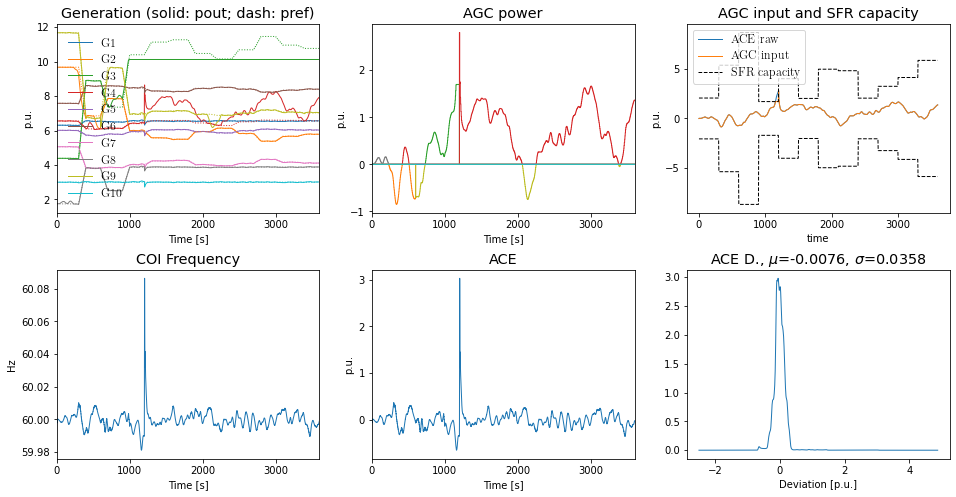

In [20]:
# plt.style.use('ieee')

right = end_time

fig_gen, ax_gen = plt.subplots(2, 3, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.2, hspace=0.3)

yheader = [f'G{i}' for i in range(1, 11)]

ssa.TDS.plt.plot(ssa.TGOV1N.pout,
                 linestyles=['-'],
                 yheader=yheader,
                 legend=True, show=False, right=right,
                 title=r'Generation (solid: pout; dash: pref)',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.pref,
                 legend=False, show=False, right=right,
                 linestyles=[':'],
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                 linestyles=['-'],
                 yheader=yheader,
                 legend=False, show=False, right=right,
                 title=r'AGC power',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[0, 1])

# Plot EV AGC response, hard code
# ax_gen[0, 1].plot(3600*(np.array(sse.tss)-10), sse.Prl, color='tab:orange', linestyle=':')
# ax_gen[0, 1].plot(3600*(np.array(sse.tss)-10), sse.Prcl, color='tab:orange', linestyle='-')
# ax_gen[0, 1].set_ylim(top=max(sse.Prl) * 1.2)

ace_res.plot(linewidth=1,
             fig=fig_gen, ax=ax_gen[0, 2],
             x='time', y='ace',
             title=f'AGC input and SFR capacity')
ace_res.plot(linewidth=1,
             fig=fig_gen, ax=ax_gen[0, 2],
             x='time', y='in',)
ace_res.plot(linewidth=1, color='k', linestyle='--',
             fig=fig_gen, ax=ax_gen[0, 2],
             x='time', y='up')
ace_res.plot(linewidth=1, color='k', linestyle='--',
             fig=fig_gen, ax=ax_gen[0, 2],
             x='time', y='dn')
ax_gen[0, 2].set_ylabel('p.u.')
ax_gen[0, 2].legend(['ACE raw', 'AGC input', 'SFR capacity'])

ssa.TDS.plt.plot(ssa.COI.omega,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 ytimes=60,
                 title=r'COI Frequency',
                 ylabel='Hz',
                 fig=fig_gen, ax=ax_gen[1, 0])

ssa.TDS.plt.plot(ssa.ACEc.ace,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 title=r'ACE',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[1, 1])

ace_tds = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy()
ace_df = pd.DataFrame()
ace_df['ace'] = ace_tds
ace_df.plot(kind='kde', legend=False, linewidth=1,
            fig=fig_gen, ax=ax_gen[1, 2],
            title=f'ACE D., $\mu$={ace_df.ace.mean().round(4)}, $\sigma$={ace_df.ace.var().round(4)}')
ax_gen[1, 2].set(xlabel='Deviation [p.u.]', ylabel='')

Text(0.5, 0, 'Time [s]')

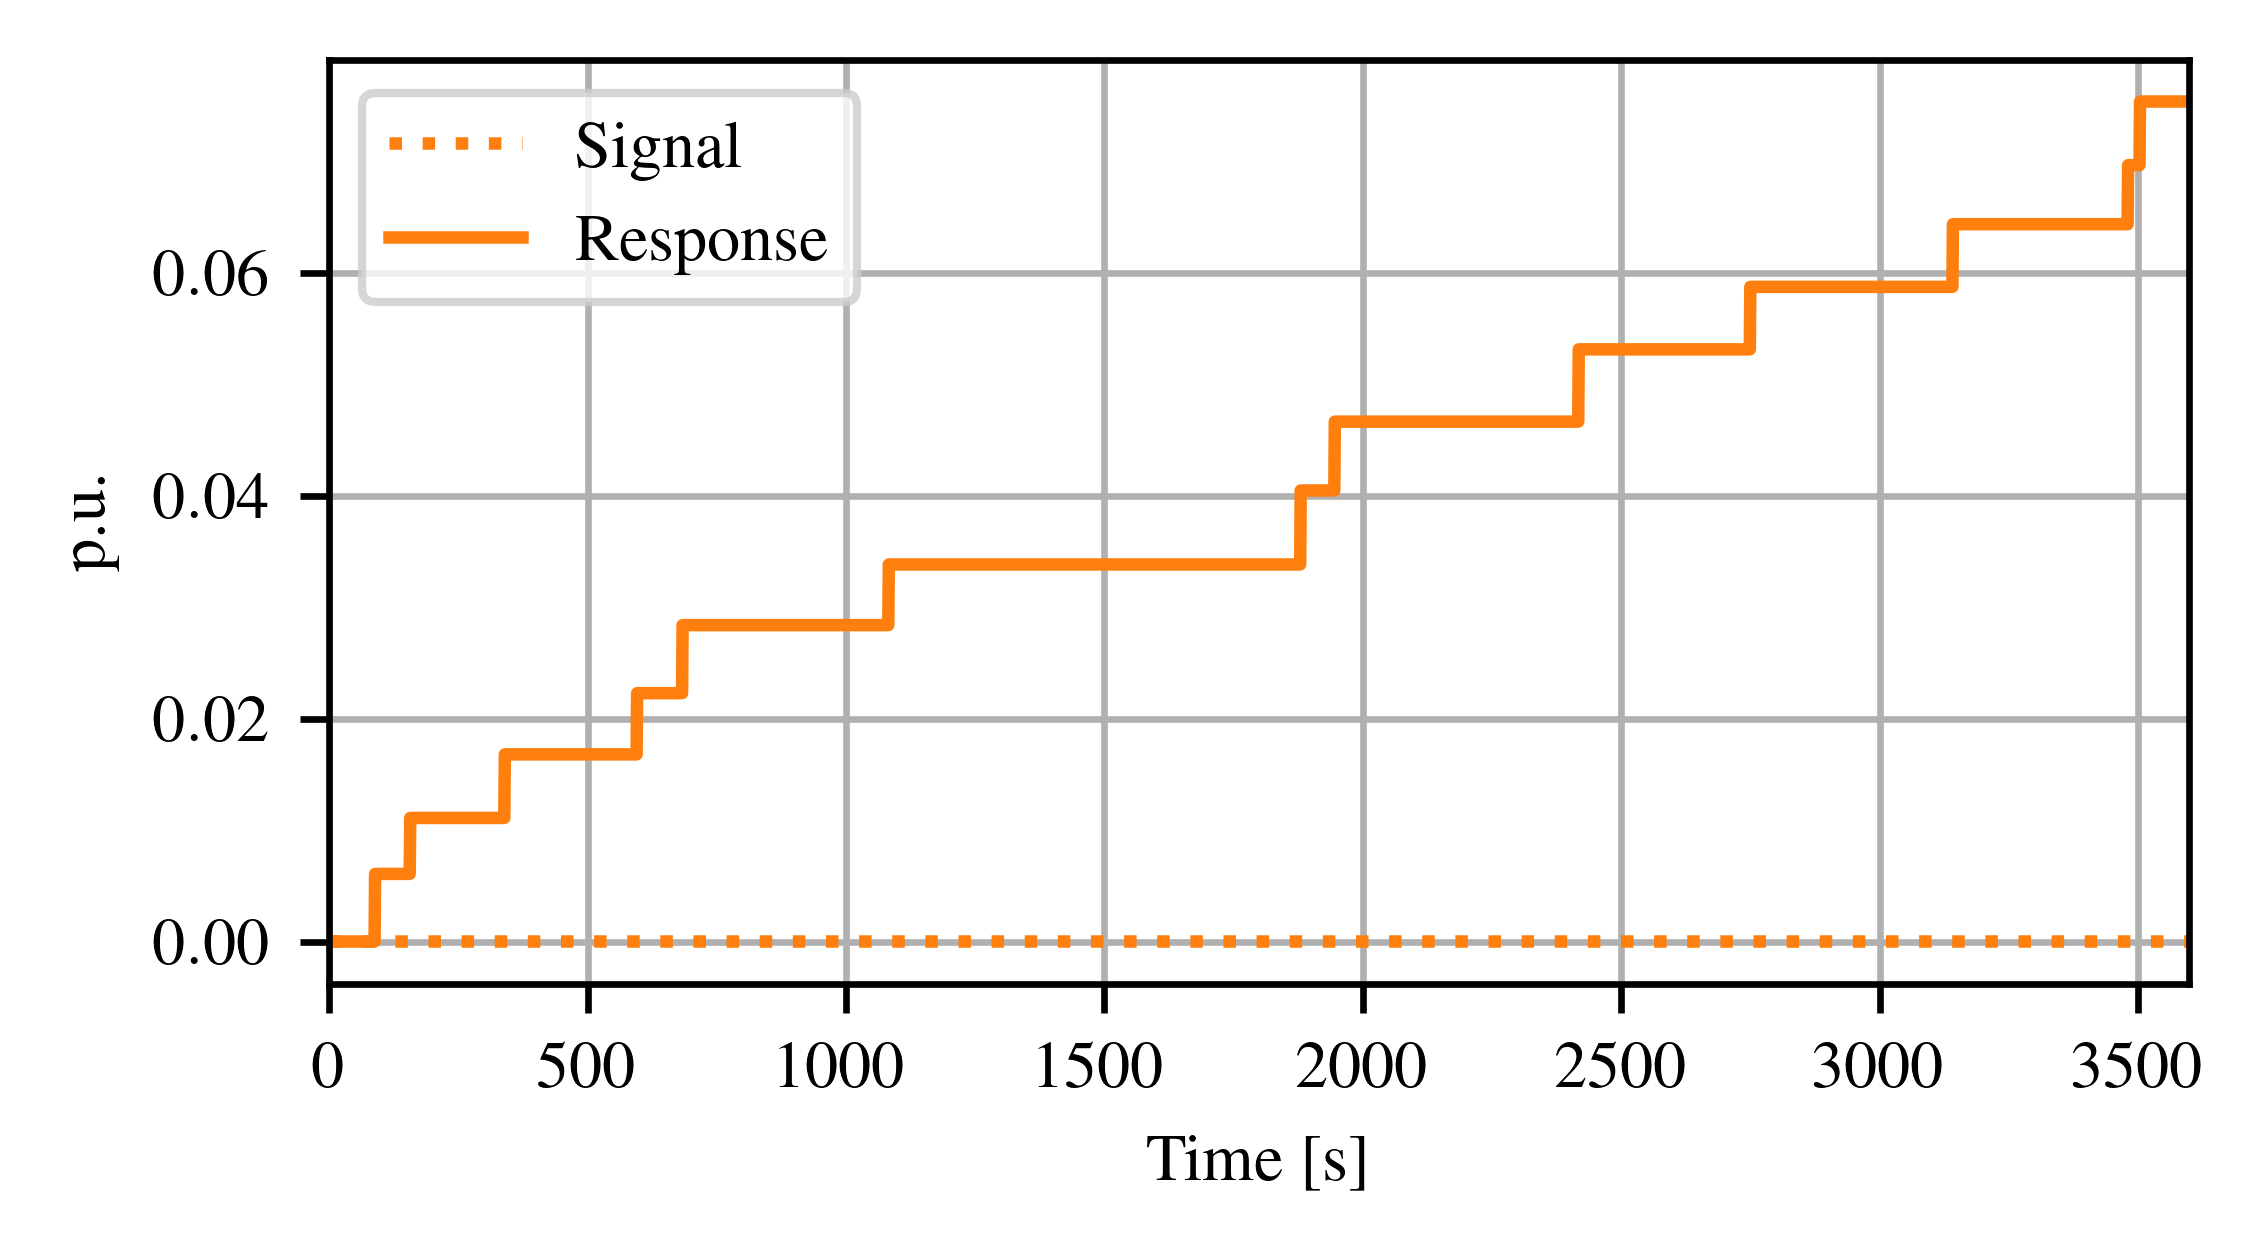

In [21]:
plt.style.use('ieee')
fige, axe = plt.subplots(figsize=(4, 2))
axe.plot(3600*(np.array(sse.tss)-10), sse.Prl, color='tab:orange', linestyle=':', label='Signal')
axe.plot(3600*(np.array(sse.tss)-10), sse.Prcl, color='tab:orange', linestyle='-', label='Response')
axe.grid()
axe.legend()
axe.set_xlim(3600*(sse.tss[0]-10), 3600*(sse.tss[-1]-10))
axe.set_ylabel('p.u.')
axe.set_xlabel('Time [s]')

(<Figure size 3600x1800 with 2 Axes>,
 <AxesSubplot:title={'center':'EVA'}, xlabel='Time [H]', ylabel='Power (MW)'>)

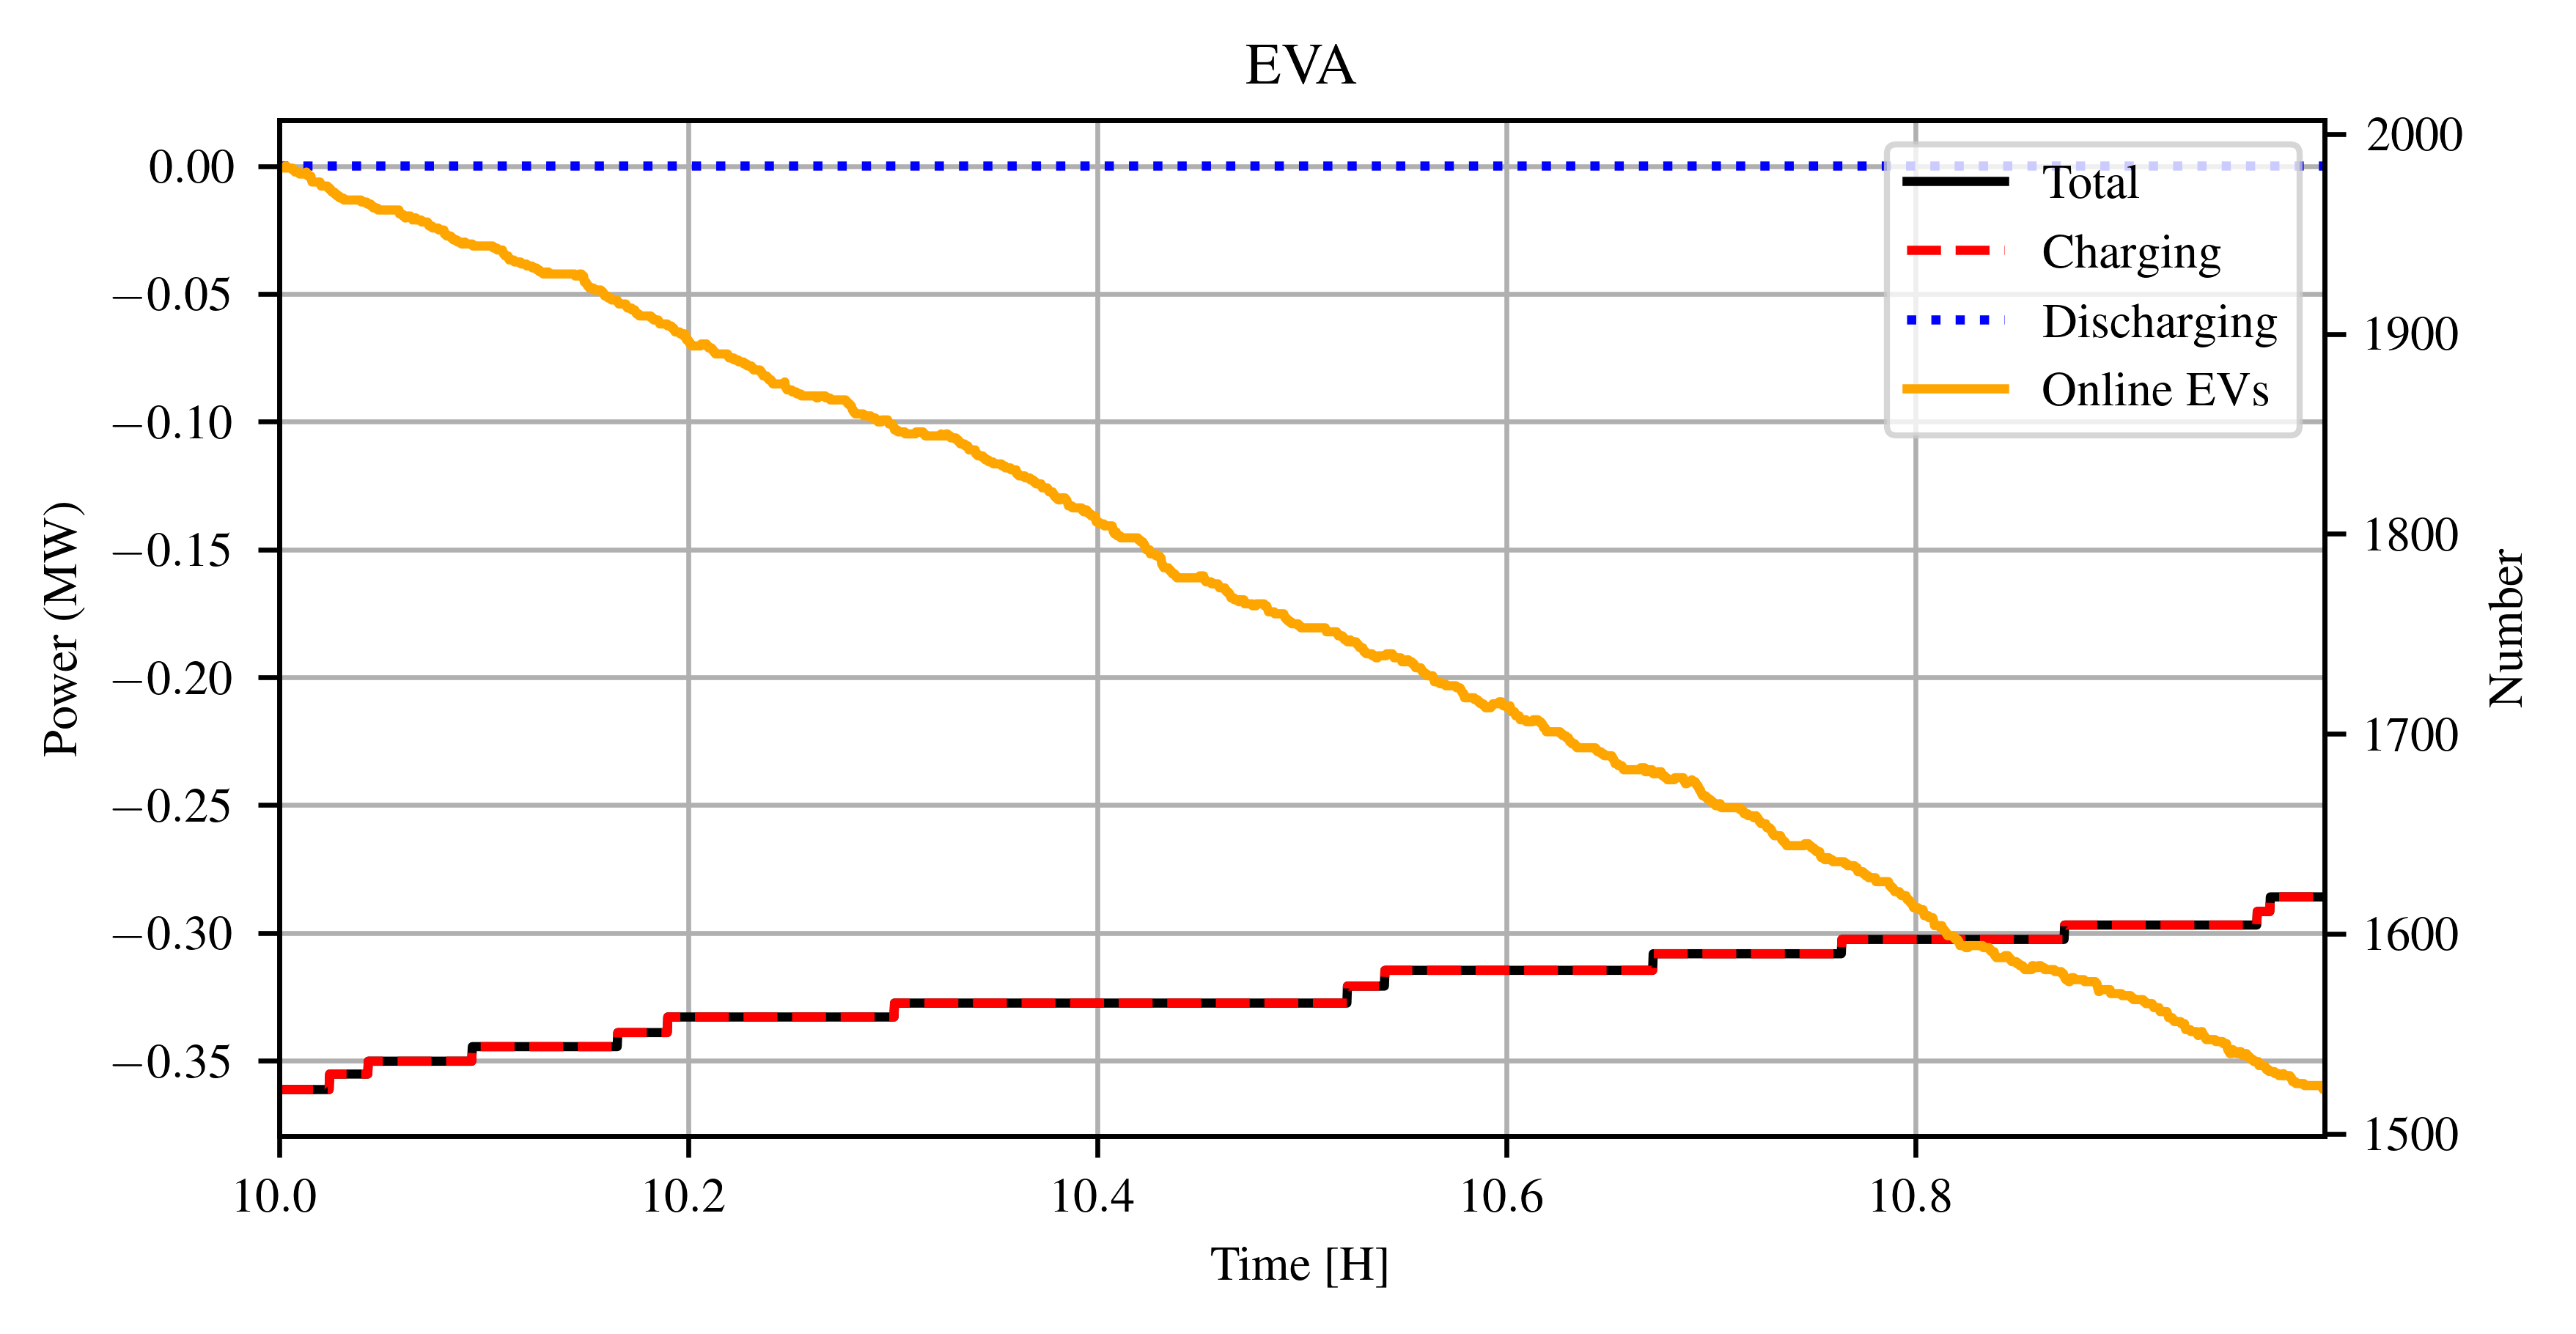

In [22]:
sse.plot(plt_style='ieee')